In [1]:
import torch
print("GPU Available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

GPU Available: False
GPU Name: No GPU


# **DATA**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

np.random.seed(42)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(0)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from collections import defaultdict, Counter

import glob
import optuna
from copy import deepcopy
from scipy.stats import mode

from IPython.display import HTML
from typing import Tuple, Optional, Union, Dict, List

In [ ]:
label_mapping = {
    # DDoS
    'DDoS-ACK_Fragmentation': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS',
    'DDoS-SlowLoris': 'DDoS',
    'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-RSTFINFlood': 'DDoS',
    'DDoS-PSHACK_Flood': 'DDoS',
    'DDoS-HTTP_Flood': 'DDoS',
    'DDoS-UDP_Fragmentation': 'DDoS',
    'DDoS-TCP_Flood': 'DDoS',
    'DDoS-SYN_Flood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS',
    'DDoS-ICMP_Fragmentation': 'DDoS',
    
    # DoS
    'DoS-TCP_Flood': 'DoS',
    'DoS-HTTP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS',
    'DoS-UDP_Flood': 'DoS',
    
    # Brute Force
    'DictionaryBruteForce': 'Brute Force',
    
    # Spoofing
    'MITM-ArpSpoofing': 'Spoofing',
    'DNS_Spoofing': 'Spoofing',
    
    # Recon
    'Recon-PingSweep': 'Recon',
    'Recon-OSScan': 'Recon',
    'VulnerabilityScan': 'Recon',
    'Recon-PortScan': 'Recon',
    'Recon-HostDiscovery': 'Recon',
    
    # Web-based
    'SqlInjection': 'Web-based',
    'CommandInjection': 'Web-based',
    'Backdoor_Malware': 'Web-based',
    'Uploading_Attack': 'Web-based',
    'XSS': 'Web-based',
    'BrowserHijacking': 'Web-based',
    
    # Mirai
    'Mirai-greip_flood': 'Mirai',
    'Mirai-greeth_flood': 'Mirai',
    'Mirai-udpplain': 'Mirai',
    
    # Benign Traffic
    'BenignTraffic': 'Benign'
}


def GroupAttacks(label):
    return label_mapping.get(label, 'Unknown') # Default to 'unknown'

df_labels = pd.read_csv(" ..\\datasets\\df_labels.csv")

def preprocessing(df, labels = df_labels):
    """ Initial data preprocessing """
    
    df = df.dropna()
    
    # Column names
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df['magnitude'] = df['magnitue']
    df = df.drop(['magnitue'], axis=1)

    # Organize label columns
    #     label           2 categories (binary): 0: BenignTraffic, 1: Attack
    #     attack_cat      8 categories: Bening, DDoS, DoS, Recon, Mirai, Web-based, Spoofing, Brute Force
    #     attack_type     34 categories: Benign and 33 attacks
    df['grouped_label'] = df['label'].map(GroupAttacks)
    df.rename(columns={'label': 'attack_type', 'grouped_label': 'attack_cat'}, inplace=True)
    df.replace({'attack_cat': {'BenignTraffic': 'Benign'}, 'attack_type': {'BenignTraffic': 'Benign'}}, inplace=True)
    df['label'] = df['attack_cat'].apply(lambda x: 0 if x == 'Benign' else 1)

    # Convert categorical labels to numerical labels
    attack_cat_map = dict(zip(labels['attack_cat_name'], labels['attack_cat_num']))
    attack_type_map = dict(zip(labels['attack_type_name'], labels['attack_type_num']))

    df['attack_cat'] = df['attack_cat'].map(attack_cat_map).astype(int)
    df['attack_type'] = df['attack_type'].map(attack_type_map).astype(int)

    # Feature Selection
    less_important_features = ['drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'http', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 'tcp', 'udp', 'dhcp', 'arp', 'icmp', 'ipv', 'llc', 'number']
    df = df.drop(columns=less_important_features)

    return df

In [ ]:
scale = StandardScaler() # Initialize a global StandardScaler for reuse across training and test sets

def ScaleData_train(df: pd.DataFrame) -> pd.DataFrame:
    """ Scales training data features using standard normalization (mean=0, std=1). """
    
    df_scaled = scale.fit_transform(df)
    return pd.DataFrame(df_scaled, columns=df.columns) 

def ScaleData_test(df: pd.DataFrame) -> pd.DataFrame:
    """ Scales test/validation data using the training data's fitted scaler """
    
    df_scaled = scale.transform(df)
    return pd.DataFrame(df_scaled, columns=df.columns) 
    

def Split(df: pd.DataFrame, training: bool) -> Tuple[pd.DataFrame, pd.Series, pd.Series]:
    """ Splits the DataFrame into features and labels, and scales features. """
    
    X = df.drop(columns=['label', 'attack_cat', 'attack_type'])
    X_scaled = ScaleData_train(X) if training else ScaleData_test(X)

    # Discard 'atack_cat' as the label will not be used in any model
    y_label = df['label']
    y_attack = df['attack_type']
    
    return X_scaled, y_label, y_attack


def to_tensor(X: Union[pd.DataFrame, torch.Tensor], y: Union[pd.Series, torch.Tensor]) -> TensorDataset:
    """ Converts input features and labels to PyTorch TensorDataset. """
    
    # Convert features to tensor if needed
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X.to_numpy(), dtype=torch.float32)

    # Convert labels to tensor if needed
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y.to_numpy(), dtype=torch.long)

    return TensorDataset(X, y)
    

def test_dataset(mode: str, limit: Optional[Union[pd.Series, torch.Tensor]] = None) -> Tuple[pd.DataFrame, Union[pd.Series, torch.Tensor]]:
    """ Prepares the test dataset for evaluation or inference. """
    
    df_test = preprocessing(pd.read_csv(" ..\\datasets\\df_test.csv"), df_labels)
    X_test, y_test_bin, y_test_multi = Split(df_test, True)

    # Choose label type based on task mode
    y_test = y_test_bin if mode == 'AD' else y_test_multi

    if mode != 'AD':
        # If a limit is provided, filter test set accordingly: only keep the values where y_test == 1 in limit
        if limit is not None:
            if isinstance(limit, torch.Tensor):
                limit = limit.numpy()  
            elif isinstance(y_test, torch.Tensor):
                y_test = y_test.numpy() 
            # Keep only samples with non-zero label and allowed by `limit`
            mask = (y_test != 0) & (limit == 1)
        else:
            mask = y_test != 0

        # Apply mask and shift labels down by 1 for class indexing
        X_test, y_test = X_test[mask], y_test[mask] - 1

    return X_test, y_test

In [5]:
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, hidden_units, activation, output_dim):
        super(DNN, self).__init__()

        layers = []
        in_features = input_dim

        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(activation())  # Activation function
            in_features = hidden_units

        # Output layer
        layers.append(nn.Linear(in_features, output_dim))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class CNN(nn.Module):
    def __init__(self, input_dim, num_filters, fc_units, dropout, num_conv_layers, output_dim):
        super(CNN, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=1 if i == 0 else num_filters, out_channels=num_filters, kernel_size=3, padding=1)
            for i in range(num_conv_layers)
        ])
        self.fc = nn.Linear(num_filters * input_dim, fc_units)
        self.output = nn.Linear(fc_units, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        for conv in self.convs:
            x = torch.relu(conv(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(torch.relu(self.fc(x)))
        x = self.output(x)
        return x
        

class CNN_LSTM(nn.Module):
    def __init__(self, input_dim, num_filters, lstm_hidden, num_layers, fc_units, dropout, num_conv_layers, output_dim):
        super(CNN_LSTM, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=1 if i == 0 else num_filters, out_channels=num_filters, kernel_size=3, padding=1)
            for i in range(num_conv_layers)
        ])
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=lstm_hidden, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, fc_units)
        self.output = nn.Linear(fc_units, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        for conv in self.convs:
            x = torch.relu(conv(x))
        x = x.permute(0, 2, 1)  # Reshape for LSTM (batch, seq_len, features)
        x, _ = self.lstm(x)
        x = self.dropout(torch.relu(self.fc(x[:, -1, :])))
        x = self.output(x)
        return x

# **PLOTS DEFINITIONS**

In [6]:
NUM_ROUNDS = 10
EPOCHS = 5
NUM_CLIENTS = 3  # Number of federated clients
input_dim = 25

In [7]:
def DisplayTable(df: pd.DataFrame) -> None:
    """ Displays the data for each unique strategy in the DataFrame as an HTML table. """
    
    for st in df['Strategy'].unique().tolist():
        metrics = df[df['Strategy'] == st]
        display(HTML(metrics.to_html(index=False)))



def AggregateNodes(df: pd.DataFrame, mode:str, partitions: str) -> pd.DataFrame:
    """ Aggregates and saves performance metrics by taking the mean for each group of (Model, Strategy, Round). """
    
    df_avg = df.groupby(['Model', 'Strategy','Round'])[['TrainAcc', 'ValAcc', 'TrainLoss']].mean().reset_index()
    df_avg.to_csv(f"/kaggle/working/{mode}_{partitions}_AvgMetrics.csv", index=False)

    return df_avg



def ImproveLabels(df_labels: pd.DataFrame) -> pd.DataFrame:
    """ Cleans and modifies attack type labels to improve readability and categorization. """
    
    df_labels = df_labels.sort_values(by=['count', 'attack_type_name'], ascending=[False, True], ignore_index=True)

    # Prefix Web-based attacks with 'WebBased-'
    mask1 = df_labels['attack_cat_name'] == 'Web-based'
    df_labels.loc[mask1, 'attack_type_name'] = 'WebBased-' + df_labels.loc[mask1, 'attack_type_name']

    # Prefix 'VulnerabilityScan' with 'Recon-'
    df_labels.loc[df_labels['attack_type_name'] == 'VulnerabilityScan', 'attack_type_name'] = 'Recon-' + df_labels.loc[df_labels['attack_type_name'] == 'VulnerabilityScan', 'attack_type_name']
    
    # Prefix Spoofing-related attack types with 'Spoofing-' and remove redundant substrings
    mask2 = df_labels['attack_cat_name'] == 'Spoofing'
    df_labels.loc[mask2, 'attack_type_name'] = ('Spoofing-' + df_labels.loc[mask2, 'attack_type_name'].str.replace('Spoofing[_-]?', '', regex=True).str.replace('_', '', regex=False))

    return df_labels

In [8]:
def AttackTypeDetection(category_counts: dict, model_dict: dict, df_labels: pd.DataFrame, extra: bool) -> None:
    """ Visualizes detection performance by attack type using a horizontal bar chart. """

    df_labels = ImproveLabels(df_labels)

    # Filter out benign labels and sort by attack_type_num
    filtered = df_labels[df_labels['attack_cat_name'] != 'Benign'].sort_values(by='attack_type_num')
    category_names = filtered['attack_type_name'].tolist()
    ordered_ids = filtered['attack_type_num'].tolist()

    
    detected_percent = [round((category_counts[cat_id]["detected"] / category_counts[cat_id]["total"]) * 100, 2) if category_counts[cat_id]["total"] > 0 else 0.0 for cat_id in ordered_ids]
    detected = [category_counts[cat_id]['detected'] for cat_id in ordered_ids]
    undetected = [category_counts[cat_id]['total'] - category_counts[cat_id]['detected'] for cat_id in ordered_ids]

    fig, ax = plt.subplots(figsize=(10, 12))
    
    # Hide plot spines
    for spine in ['left', 'right', 'top', 'bottom']:
        ax.spines[spine].set_visible(False)

    y_pos = np.arange(len(category_names))

    ax.barh(y_pos, detected, color='black', label='Detected')
    ax.barh(y_pos, undetected, left=detected, color='lightgray', label='Undetected')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(category_names)
    ax.set_ylabel("Attack Type")

    ax.set_xticks([])            
    ax.set_xticklabels([])         
    ax.xaxis.set_visible(False)

    data = 'Test Dataset' if model_dict['AD Model'][-1] == "Test Dataset" else "AD output"
    mode = 'AC-DP' if extra else 'AC'
    plt.suptitle(f"{mode} {model_dict['Partition'][-1]} - Detection by Attack Type from {data}", fontsize=20, fontweight='bold', x=0.5, ha='center')
    if extra:
        ax.set_title(f"Arch: {model_dict['Model'][-1]} - Agg function: {model_dict['Strategy'][-1]} - Global rounds: 10 - Local epochs: 5 - Epsilon: {model_dict['Conf'][-1].split('-')[0]} - Clipping thr: {model_dict['Conf'][-1].split('-')[-1]}", ha='center', va='center', x=0.5, fontsize=12, pad=0)
    else:
        ax.set_title(f"Architecture: {model_dict['Model'][-1]} - Aggregation function: {model_dict['Strategy'][-1]} - Global rounds: 10 - Local epochs: 5", ha='center', va='center', x=0.5, fontsize=13, pad=0)
    
    for i, (det, undet, perc) in enumerate(zip(detected, undetected, detected_percent)):
        total = det + undet
        ax.text(total + 17, y_pos[i], f"{det}/{total} ({perc:.2f}%)", va='center')

    plt.gca().invert_yaxis()
    ax.legend()
    plt.tight_layout()
    plt.show()



def AbsoluteMisclassification(category_counts: dict, model_dict: dict, extra: bool, num_classes: int = 33) -> None:
    """ Displays a confusion matrix showing prediction errors between true and predicted attack types. """

    error_matrix = pd.DataFrame(0, index=range(1, num_classes+1), columns=range(1, num_classes+1))

    # Fill matrix with misclassified counts
    for true_label, counts in category_counts.items():
        for pred_label in counts['errors']:
            error_matrix.at[true_label, pred_label] += 1

    mask = error_matrix == 0 # mask for cleaner heatmap
    
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(error_matrix, annot=True, fmt='d', cmap="Reds", cbar=True, linewidths=0.5, linecolor='gray', mask=mask, vmax=2000 )

    data = 'Test Dataset' if model_dict['AD Model'][-1] == "Test Dataset" else "AD output"
    mode = 'AC-DP' if extra else 'AC'
    fig.suptitle(f"{mode} {model_dict['Partition'][-1]} - Misclassification by Attack Type from {data}", x=0.5, fontsize=20, fontweight='bold', ha='center')

    if extra:
        ax.set_title(f"Arch: {model_dict['Model'][-1]} - Agg function: {model_dict['Strategy'][-1]} - Global rounds: 10 - Local epochs: 5 - Epsilon: {model_dict['Conf'][-1].split('-')[0]} - Clipping threshold: {model_dict['Conf'][-1].split('-')[-1]}", ha='center', va='center', x=0.5, fontsize=12, pad=15)
    else:
        ax.set_title(f"Architecture: {model_dict['Model'][-1]} - Aggregation function: {model_dict['Strategy'][-1]} - Global rounds: 10 - Local epochs: 5", ha='center', va='center', x=0.5, fontsize=13, pad=15)
  
    plt.xlabel("Predicted Label",  fontsize=12)
    plt.ylabel("True Label",  fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def FullConfusionMatrix(category_counts: dict, model_dict: dict, extra: bool, num_classes: int = 33) -> None:
    """ Displays a full confusion matrix, including both correct and incorrect classifications. """

    confusion_matrix = pd.DataFrame(0, index=range(1, num_classes+1), columns=range(1, num_classes+1))

    # Fill matrix with misclassified counts
    for true_label, counts in category_counts.items():
        confusion_matrix.at[true_label, true_label] += counts.get('detected', 0)
        
        for pred_label in counts['errors']:
            confusion_matrix.at[true_label, pred_label] += 1

    mask = confusion_matrix == 0 # mask for cleaner heatmap
    
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Reds", cbar=True, linewidths=0.5, linecolor='gray', mask=mask, vmax=2000 )

    data = 'Test Dataset' if model_dict['AD Model'][-1] == "Test Dataset" else "AD output"
    mode = 'AC-DP' if extra else 'AC'
    fig.suptitle(f"{mode} {model_dict['Partition'][-1]} - Full Confusion Matrix from {data}", x=0.5, fontsize=20, fontweight='bold', ha='center')

    if extra:
        ax.set_title(f"Arch: {model_dict['Model'][-1]} - Agg function: {model_dict['Strategy'][-1]} - Global rounds: 10 - Local epochs: 5 - Epsilon: {model_dict['Conf'][-1].split('-')[0]} - Clipping threshold: {model_dict['Conf'][-1].split('-')[-1]}", ha='center', va='center', x=0.5, fontsize=12, pad=15)
    else:
        ax.set_title(f"Architecture: {model_dict['Model'][-1]} - Aggregation function: {model_dict['Strategy'][-1]} - Global rounds: 10 - Local epochs: 5", ha='center', va='center', x=0.5, fontsize=13, pad=15)
  
    plt.xlabel("Predicted Label",  fontsize=12)
    plt.ylabel("True Label",  fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    

def CategoryConfusionMatrix(category_counts: dict, model_dict: dict, df_labels: pd.DataFrame, extra: bool) -> None:
    """ Displays a confusion matrix of misclassification counts between attack category predictions. """

    # Map attack type numbers to category names, excluding benign
    label_map = df_labels[df_labels['attack_cat_name'] != 'Benign'].set_index('attack_type_num')['attack_cat_name'].to_dict()

    matrix = defaultdict(lambda: defaultdict(int))

    for true_label, stats in category_counts.items():
        true_cat = label_map.get(true_label, "Unknown")

        # Correct predictions (true category == predicted category)
        matrix[true_cat][true_cat] += stats['detected']

        # Incorrect predictions
        for pred_label in stats['errors']:
            if pred_label == 34:
                continue
            pred_cat = label_map.get(pred_label, "Unknown")
            matrix[true_cat][pred_cat] += 1

    all_cats = sorted(set(label_map.values()))
    confusion_df = pd.DataFrame(0, index=all_cats, columns=all_cats)

    for true_cat, preds in matrix.items():
        for pred_cat, count in preds.items():
            confusion_df.loc[true_cat, pred_cat] += count

    plt.figure(figsize=(12, 5))
    sns.heatmap(confusion_df, annot=True, fmt='d', cmap="Greys", cbar=True, linewidths=0.5, linecolor='gray', vmax=3000 )

    mode = 'AC-DP' if extra else 'AC'
    data = 'Test Dataset' if model_dict['AD Model'][-1] == "Test Dataset" else "AD output"
    plt.suptitle(f"{mode} {model_dict['Partition'][-1]} - Classification by Attack Category from {data}", fontsize=20, fontweight='bold', ha='center')

    if extra:
        plt.title(f"Arch: {model_dict['Model'][-1]} - Agg function: {model_dict['Strategy'][-1]} - Global rounds: 10 - Local epochs: 5 - Epsilon: {model_dict['Conf'][-1].split('-')[0]} - Clipping threshold: {model_dict['Conf'][-1].split('-')[-1]}", ha='center', va='center', fontsize=12, pad=15)
    else:
        plt.title(f"Architecture: {model_dict['Model'][-1]} - Aggregation function: {model_dict['Strategy'][-1]} - Global rounds: 10 - Local epochs: 5", ha='center', va='center', fontsize=13, pad=15)
    
    plt.xlabel("Predicted Label",  fontsize=12)
    plt.ylabel("True Label",  fontsize=12)
    # plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# **EVALUATION**

In [9]:
def TrackPredictions(y_true: Union[List[int], np.ndarray], y_pred: Union[List[int], np.ndarray]) -> Dict[int, Dict[str, Union[int, List[int]]]]:
    """ Tracks total samples, correct detections, and prediction errors per attack type. """

    # Initialize counts for each label: total samples, correct detections, and list of errors
    category_counts = defaultdict(lambda: {'total': 0, 'detected': 0, 'errors': []})
    
    for true_label, pred_label in zip(y_true, y_pred): 
        true_label, pred_label = int(true_label), int(pred_label)
        category_counts[true_label]['total'] += 1
        
        if true_label == pred_label: # Correct prediction
            category_counts[true_label]['detected'] += 1
        else: # Count misclassifications
            category_counts[true_label]['errors'].append(pred_label)

    return category_counts


def metrics_dict(model_dict: Dict[str, List[Union[float, List[float]]]], y_true: Union[List[int], np.ndarray], y_pred: Union[List[int], np.ndarray], avg_mode: str = 'macro') -> Dict[str, List[Union[float, List[float]]]]:
    """ Calculates evaluation metrics and appends them to the given model dictionary. """
    
    # Global metrics
    Accuracy = balanced_accuracy_score(y_true, y_pred)
    Precision = precision_score(y_true, y_pred, average=avg_mode, zero_division=0)
    Recall = recall_score(y_true, y_pred, average=avg_mode, zero_division=0)
    F1 = f1_score(y_true, y_pred, average=avg_mode, zero_division=0)
    MCC = matthews_corrcoef(y_true, y_pred)

    # Per-class metrics
    Precision_indiv = precision_score(y_true, y_pred, average=None, zero_division=0)
    Recall_indiv = recall_score(y_true, y_pred, average=None, zero_division=0)
    F1_indiv = f1_score(y_true, y_pred, average=None, zero_division=0)

    # Append each metric (rounded) to the model_dict
    metrics = { "Precision": Precision, "Precision (Indiv)": Precision_indiv, "Recall": Recall, "Recall (Indiv)": Recall_indiv, "F1-score": F1, "F1-score (Indiv)": F1_indiv, "Accuracy": Accuracy, "MCC": MCC }
    
    for metric, value in metrics.items():
        if isinstance(value, (list, np.ndarray)):
            rounded_value = [round(v * 100, 2) for v in value] # Per-class metrics
        else:
            rounded_value = round(value * 100, 2) # Scalar metric
        model_dict[metric].append(rounded_value)

    return model_dict

In [10]:
def evaluation(model, X, y_true, df_labels: pd.DataFrame, batch: int, model_dict: Dict[str, List]) -> Tuple[Dict[str, List], Optional[Dict[str, List]], torch.Tensor]:
    """ 
    Evaluate a classification model using multiple metrics for both binary and multi-class classification.
    
    Evaluation metrics:
        Precision:   TP / (TP + FP) 
        Recall:      TP / (TP + FN)                                                                      -> True Positive Ratio (TPR)
        F1:          (2 * Precision * Recall) / (Precision + Recall)   
        Accuracy:    (TP + TN) / (TP + TN + FP + FN)
        FPR:         FP / (FP + TN)                                                                      -> False Positive Ratio (FPR)
        FNR:         FN / (TP + FN)                                                                      -> False Negative Ratio (FNR)
        MCC:         ((TP * TN) - (FP * FN)) / (np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)))  -> Matthews Correlation Coefficient
    """
 
    dataloader = DataLoader(to_tensor(X, y_true), batch_size=2**batch, shuffle=False)
    model.eval()
    all_preds, all_labels = [], []
    all_max_probs = []
    
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            y_pred = model(batch_X)
            
            y_pred = y_pred 
            y_pred = torch.argmax(y_pred, dim=1)

            all_preds.append(y_pred.cpu())
            all_labels.append(batch_y.cpu())
            
    y_pred, y_true = torch.cat(all_preds), torch.cat(all_labels)

    cm = confusion_matrix(y_true.cpu(), y_pred.cpu()) # Compute confusion matrix

    # Binary classification case
    if cm.shape == (2, 2): 
        TN, FP, FN, TP = cm.ravel()
        
        Precision = TP / (TP + FP)                                                               # Same as: precision_score(y_true, y_pred)
        Recall = TP / (TP + FN)                                                                  # Same as: recall_score(y_true, y_pred)
        F1 = (2 * Precision * Recall) / (Precision + Recall)                                     # Same as: f1_score(y_true, y_pred)
        Accuracy = (TP + TN) / (TP + TN + FP + FN)                                               # Same as: accuracy_score(y_true, y_pred)
        FNR = FN / (TP + FN) 
        FPR = FP / (FP + TN) 

        TP, TN, FP, FN = float(TP), float(TN), float(FP), float(FN) # To avoid overflow
        MCC = ((TP * TN) - (FP * FN)) / (np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))) # Same as: matthews_corrcoef(y_true, y_pred)

        metrics = { "Precision": Precision, "Recall": Recall, "F1-score": F1, "Accuracy": Accuracy, "FNR": FNR, "FPR": FPR, "MCC": MCC }
        
        for metric, value in metrics.items():
            rounded_value = round(value * 100, 2)
            print(f"{metric}: {rounded_value}%")
            model_dict[metric].append(rounded_value)

        # Display classification report
        print(f"\nClassification Report\n{classification_report(y_true, y_pred, target_names=['Benign', 'Attack'])}")

        # Confusion matrix plot
        disp_attacks = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign\nTraffic', "Malicious\nTraffic"])
        disp_attacks.plot(cmap="Greys", values_format="d")  # 'd' for integer values
        disp_attacks.im_.set_clim(0, 109900)
        
        if model_dict['Conf'][-1]:
            plt.suptitle(f"{MODE}-DP - {model_dict['Partition'][-1]} - {model_dict['Model'][-1]} - Attacks' Confusion Matrix", fontweight='bold')
            plt.title(f"Epsilon: {model_dict['Conf'][-1].split('-')[0]}, Clipping threshold: {model_dict['Conf'][-1].split('-')[-1]}", fontsize=10)
        else:
            plt.title(f"{MODE} - {model_dict['Partition'][-1]} - {model_dict['Model'][-1]} - Attacks' Confusion Matrix", fontweight='bold')
            
        plt.show()

    # Multi-class classification case
    else: 
        model_dict = metrics_dict(model_dict, y_true, y_pred)

        # Convert predictions back to the original 1-33 range as the model was trained in the 0-32 range
        category_counts = TrackPredictions(y_true + 1, y_pred + 1)

        extra = True if model_dict['Conf'][-1] else False

        # Visual and metric analyses
        AttackTypeDetection(category_counts, model_dict, df_labels, extra)
        AbsoluteMisclassification(category_counts, model_dict, extra)
        FullConfusionMatrix(category_counts, model_dict, extra)
        CategoryConfusionMatrix(category_counts, model_dict, df_labels, extra)

    return model_dict, y_pred

In [ ]:
def compute_divergences(model1: torch.nn.Module, model2: torch.nn.Module, X, y_true, batch: int, device: str = 'cpu') -> Tuple[float, float, float]:
    """ Compute the KL and Jensen-Shannon divergences between two models' output distributions. """

    test_loader = DataLoader(to_tensor(X, y_true), batch_size=2**batch, shuffle=False)
    
    model1.eval()
    model2.eval()
    model1.to(device)
    model2.to(device)

    kl_12_divs = []  # KL(model1 || model2)
    kl_21_divs = []  # KL(model2 || model1)
    js_divs = []     # JS divergence

    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)

            # Predict and convert to probability distributions
            probs1 = F.softmax(model1(X_batch), dim=1) + 1e-8
            probs2 = F.softmax(model2(X_batch), dim=1) + 1e-8

            # KL divergence from model1 to model2: KL(model1 || model2)
            kl_12_batch = torch.sum(probs1 * torch.log(probs1 / probs2), dim=1)
            kl_12_divs.extend(kl_12_batch.cpu().numpy())

            # KL divergence from model2 to model1: KL(model2 || model1)
            kl_21_batch = torch.sum(probs2 * torch.log(probs2 / probs1), dim=1)
            kl_21_divs.extend(kl_21_batch.cpu().numpy())

            # Jensen-Shannon divergence
            M = 0.5 * (probs1 + probs2)
            js_batch = 0.5 * (
                torch.sum(probs1 * torch.log(probs1 / M), dim=1) +
                torch.sum(probs2 * torch.log(probs2 / M), dim=1)
            )
            js_divs.extend(js_batch.cpu().numpy())

    avg_kl_12 = float(np.mean(kl_12_divs))
    avg_kl_21 = float(np.mean(kl_21_divs))
    avg_js = float(np.mean(js_divs))
    return avg_kl_12, avg_kl_21, avg_js

## **Attack Detection**

In [12]:
MODE = 'AD'
CLASSES = 2 if MODE == 'AD' else 33

X_test, y_test = test_dataset(MODE)

# Best known hyperparameters per model
AD_model_best_params = {
    'DNN': {'hidden_layers': 3, 'hidden_units': 58, 'activation': 'Tanh', 'learning_rate': 3e-3, 'optimizer': 'Adam', 'batch_size': 9},
    'CNN': {'num_filters': 115, 'fc_units': 60, 'dropout': 0.17, 'num_conv_layers': 3, 'learning_rate': 2e-4, 'optimizer': 'Adam', 'batch_size': 7},
    'CNN-LSTM': {'num_filters': 114, 'lstm_hidden': 64, 'num_layers': 1, 'fc_units': 49, 'dropout': 0.43, 'num_conv_layers': 3, 'learning_rate': 3e-4, 'optimizer': 'Adam', 'batch_size': 5}
}

# Activation function resolver
def define_activation_fn(activation_name: str):
    activation_dict = {
        "ReLU": torch.nn.ReLU,
        "LeakyReLU": torch.nn.LeakyReLU,
        "Tanh": torch.nn.Tanh
    }
    return activation_dict[activation_name]

# Instantiate base model architectures
AD_models = {
    'DNN': DNN(input_dim, hidden_layers = AD_model_best_params['DNN']['hidden_layers'], hidden_units = AD_model_best_params['DNN']['hidden_units'], activation = define_activation_fn(AD_model_best_params['DNN']['activation']), output_dim=CLASSES),
    'CNN': CNN(input_dim,  AD_model_best_params['CNN']['num_filters'], AD_model_best_params['CNN']['fc_units'],  AD_model_best_params['CNN']['dropout'],  AD_model_best_params['CNN']['num_conv_layers'], output_dim=CLASSES),
    'CNN-LSTM': CNN_LSTM(input_dim, AD_model_best_params['CNN-LSTM']['num_filters'], AD_model_best_params['CNN-LSTM']['lstm_hidden'],  AD_model_best_params['CNN-LSTM']['num_layers'], AD_model_best_params['CNN-LSTM']['fc_units'], AD_model_best_params['CNN-LSTM']['dropout'],  AD_model_best_params['CNN-LSTM']['num_conv_layers'], output_dim=CLASSES)
}


 ============== AD UNIFORM PARTITIONS: CNN (GeomMedian) ==============
Precision: 97.52%
Recall: 92.16%
F1-score: 94.76%
Accuracy: 95.29%
FNR: 7.84%
FPR: 2.01%
MCC: 90.62%

Classification Report
              precision    recall  f1-score   support

      Benign       0.94      0.98      0.96    109820
      Attack       0.98      0.92      0.95     94337

    accuracy                           0.95    204157
   macro avg       0.96      0.95      0.95    204157
weighted avg       0.95      0.95      0.95    204157



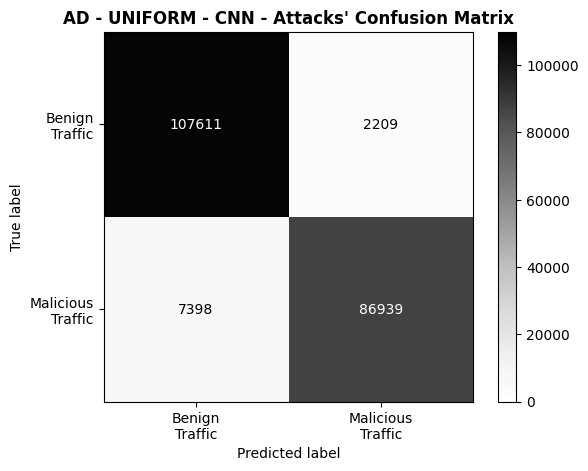


 ============== AD UNIFORM PARTITIONS: CNN (GeomMedian) ==============
 --------------- DP configuration: eps = 2, max_grad_norm = 1 --------------- 
Precision: 97.08%
Recall: 88.47%
F1-score: 92.58%
Accuracy: 93.44%
FNR: 11.53%
FPR: 2.28%
MCC: 87.03%

Classification Report
              precision    recall  f1-score   support

      Benign       0.91      0.98      0.94    109820
      Attack       0.97      0.88      0.93     94337

    accuracy                           0.93    204157
   macro avg       0.94      0.93      0.93    204157
weighted avg       0.94      0.93      0.93    204157



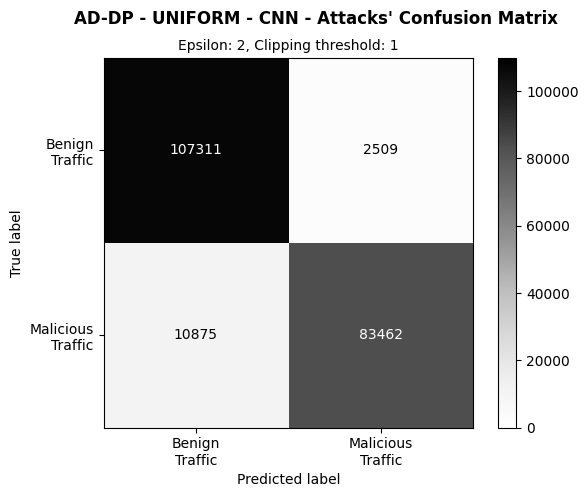


 ============== AD UNBALANCED PARTITIONS: CNN (GeomMedian) ==============
Precision: 98.21%
Recall: 91.29%
F1-score: 94.62%
Accuracy: 95.2%
FNR: 8.71%
FPR: 1.43%
MCC: 90.5%

Classification Report
              precision    recall  f1-score   support

      Benign       0.93      0.99      0.96    109820
      Attack       0.98      0.91      0.95     94337

    accuracy                           0.95    204157
   macro avg       0.96      0.95      0.95    204157
weighted avg       0.95      0.95      0.95    204157



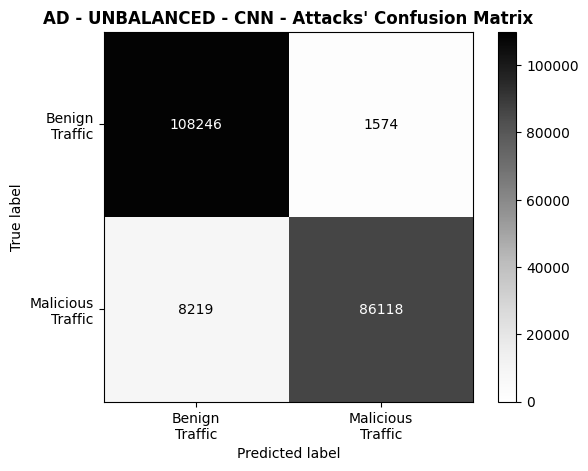


 ============== AD UNBALANCED PARTITIONS: CNN (GeomMedian) ==============
 --------------- DP configuration: eps = 2, max_grad_norm = 1 --------------- 
Precision: 97.48%
Recall: 88.06%
F1-score: 92.53%
Accuracy: 93.43%
FNR: 11.94%
FPR: 1.95%
MCC: 87.06%

Classification Report
              precision    recall  f1-score   support

      Benign       0.91      0.98      0.94    109820
      Attack       0.97      0.88      0.93     94337

    accuracy                           0.93    204157
   macro avg       0.94      0.93      0.93    204157
weighted avg       0.94      0.93      0.93    204157



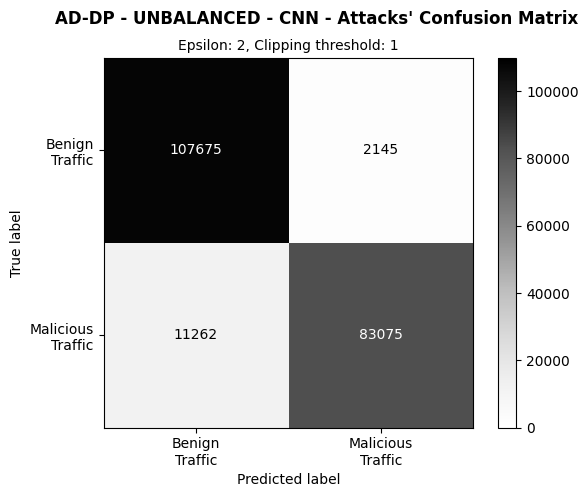

In [ ]:
# Results tracking dictionary
AD_models_dict = {'Model': [], 'Mode': [], 'Partition': [], 'Strategy': [], 'Conf': [], 'Precision': [], 'Recall': [],  'F1-score': [], 'Accuracy': [], 'FNR': [], 'FPR': [], 'MCC':[]}

# Chosen model and evaluation strategy
AD_model_name = "CNN"
AD_model = deepcopy(AD_models[AD_model_name])
AD_models_test = {}
AD_agg_funct = "GeomMedian"
AD_y_pred = {}

ADDP = {'AD2': 1, 'AD2-HT': 4.15} # Differential Privacy configurations: eps value mappings

# Main evaluation loop over dataset partitions and DP configurations
for AD_partition in ["UNIFORM", "UNBALANCED"]:
    for conf in ['', '2']: # '' = No DP, '2' = DP
        extra = f"_DP{conf}" if conf else ''
        path = "DP/" if conf else ''

        # Load model weights
        AD_models_test[f"{AD_partition}-{MODE}{EPOCHS}{extra}"] = deepcopy(AD_model)
        AD_models_test[f"{AD_partition}-{MODE}{EPOCHS}{extra}"].load_state_dict(torch.load(glob.glob(f"..\\models\\{MODE}\\{path}{MODE}{EPOCHS}{extra}_{AD_partition}_{AD_model_name}_{AD_agg_funct}_r9.pth")[0], weights_only=True, map_location=device))

        # Metadata logging
        AD_models_dict['Model'].append(AD_model_name)
        AD_models_dict['Mode'].append(f"{MODE}-DP" if conf else MODE)
        AD_models_dict['Strategy'].append(AD_agg_funct)
        AD_models_dict['Partition'].append(AD_partition)
        AD_models_dict['Conf'].append(f"{conf}-{ADDP[f'{MODE}{conf}']}" if conf else None)
        
        print(f"\n ============== {MODE} {AD_partition} PARTITIONS: {AD_model_name} ({AD_agg_funct}) ==============")
        if conf: 
            print(f" --------------- DP configuration: eps = {conf.split('-')[0]}, max_grad_norm = {ADDP[f'{MODE}{conf}']} --------------- ")

        # Evaluate model and update metrics
        AD_models_dict, AD_y_pred[f"{AD_partition}-{MODE}{EPOCHS}{extra}"] = evaluation(AD_models_test[f"{AD_partition}-{MODE}{EPOCHS}{extra}"], X_test, y_test, df_labels, AD_model_best_params[AD_model_name]['batch_size'], AD_models_dict)

# Display summarized metrics table
DisplayTable(pd.DataFrame(AD_models_dict))

In [14]:
for partition in ["UNIFORM", "UNBALANCED"]:
    modelNODP = AD_models_test[f"{partition}-AD5"]
    modelDP = AD_models_test[f"{partition}-AD5_DP2"]

    print(f"\n ============== {MODE} {partition} PARTITIONS ============== ")

    # Compare output distributions of DP vs non-DP model
    kl_nodp_dp, kl_dp_nodp, js_nodp = compute_divergences(modelNODP, modelDP, X_test, y_test, AD_model_best_params[AD_model_name]['batch_size'])
    
    print(f"\nKL Divergence (non-DP || DP): {kl_nodp_dp:.4f}") # How much info is lost using model2 (DP) to approximate model1 (non-DP)
    print(f"KL Divergence (DP || non-DP): {kl_dp_nodp:.4f}")
    print(f"Jensen-Shannon Divergence:     {js_nodp:.4f}")


 ============== AD UNIFORM PARTITIONS ============== 

KL Divergence (non-DP || DP): 0.2033
KL Divergence (DP || non-DP): 0.1341
Jensen-Shannon Divergence:     0.0219

 ============== AD UNBALANCED PARTITIONS ============== 

KL Divergence (non-DP || DP): 0.1912
KL Divergence (DP || non-DP): 0.1229
Jensen-Shannon Divergence:     0.0204


## **Attack Classification**

In [15]:
MODE = 'AC'
CLASSES = 2 if MODE == 'AD' else 33

# Best known hyperparameters per model
AC_model_best_params = {
    'CNN': {'num_filters': 51, 'fc_units': 55, 'dropout': 0.1, 'num_conv_layers': 3, 'learning_rate': 1.4e-3, 'optimizer': 'RMSprop', 'batch_size': 7},
    'CNN-GAN': {'num_filters': 71, 'fc_units': 44, 'dropout': 0.23, 'num_conv_layers': 3, 'learning_rate': 1.16e-3, 'optimizer': 'Adam', 'batch_size': 7},
    'CNN-LSTM': {'num_filters': 71, 'lstm_hidden': 28, 'num_layers': 2, 'fc_units': 61, 'dropout': 0.384, 'num_conv_layers': 1, 'learning_rate': 1.62e-3, 'optimizer': 'RMSprop', 'batch_size': 5},
}

# Instantiate base model architectures
AC_models = {
    'CNN': CNN(input_dim,  AC_model_best_params['CNN']['num_filters'],  AC_model_best_params['CNN']['fc_units'],  AC_model_best_params['CNN']['dropout'],  AC_model_best_params['CNN']['num_conv_layers'], output_dim=CLASSES),
    'CNN-GAN': CNN(input_dim,  AC_model_best_params['CNN-GAN']['num_filters'],  AC_model_best_params['CNN-GAN']['fc_units'],  AC_model_best_params['CNN-GAN']['dropout'],  AC_model_best_params['CNN-GAN']['num_conv_layers'], output_dim=CLASSES),
    'CNN-LSTM': CNN_LSTM(input_dim, AC_model_best_params['CNN-LSTM']['num_filters'], AC_model_best_params['CNN-LSTM']['lstm_hidden'],  AC_model_best_params['CNN-LSTM']['num_layers'], AC_model_best_params['CNN-LSTM']['fc_units'], AC_model_best_params['CNN-LSTM']['dropout'],  AC_model_best_params['CNN-LSTM']['num_conv_layers'], output_dim=CLASSES),
}


 ============== AC UNIFORM PARTITIONS: CNN (GeomMedian) ==============


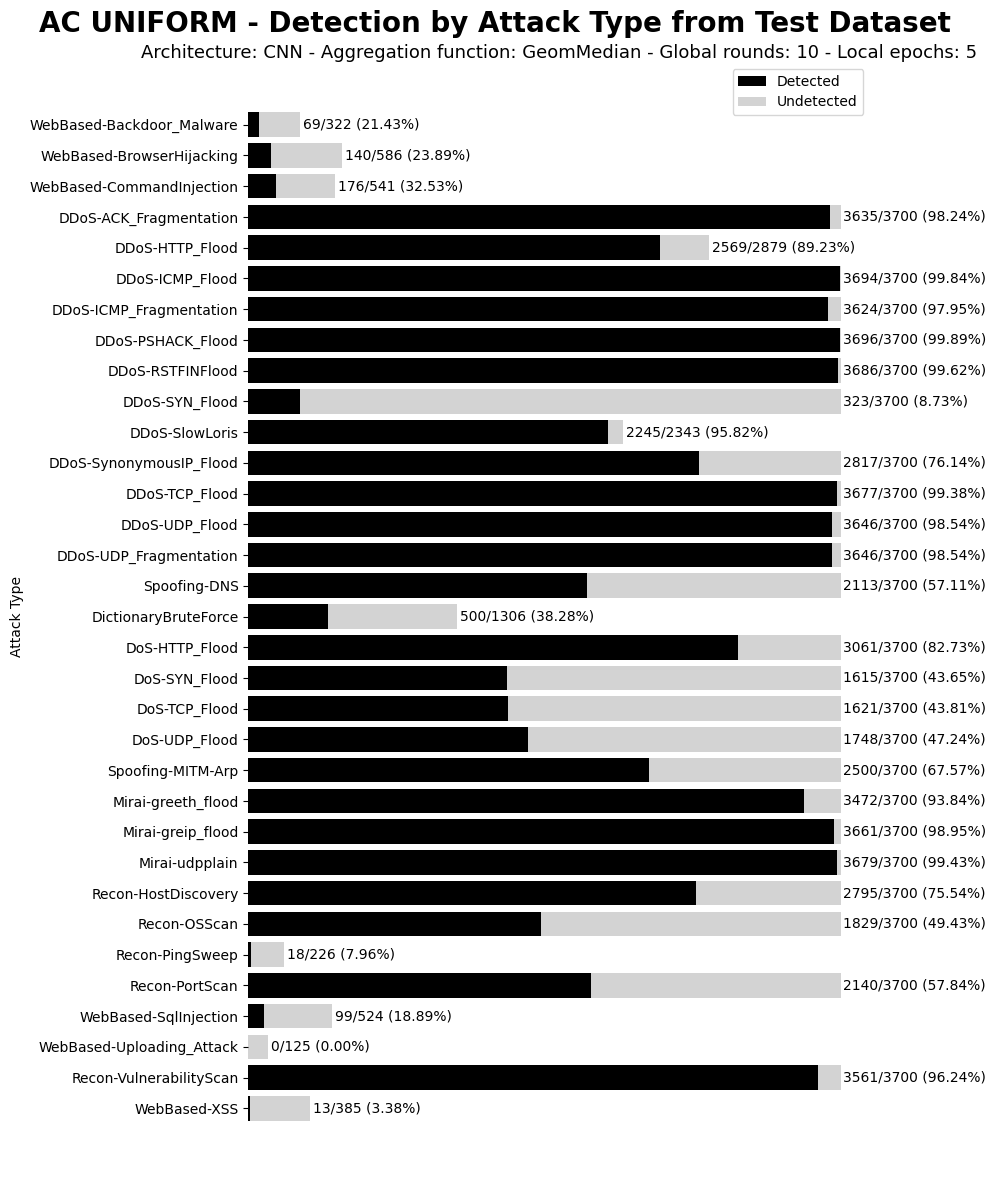

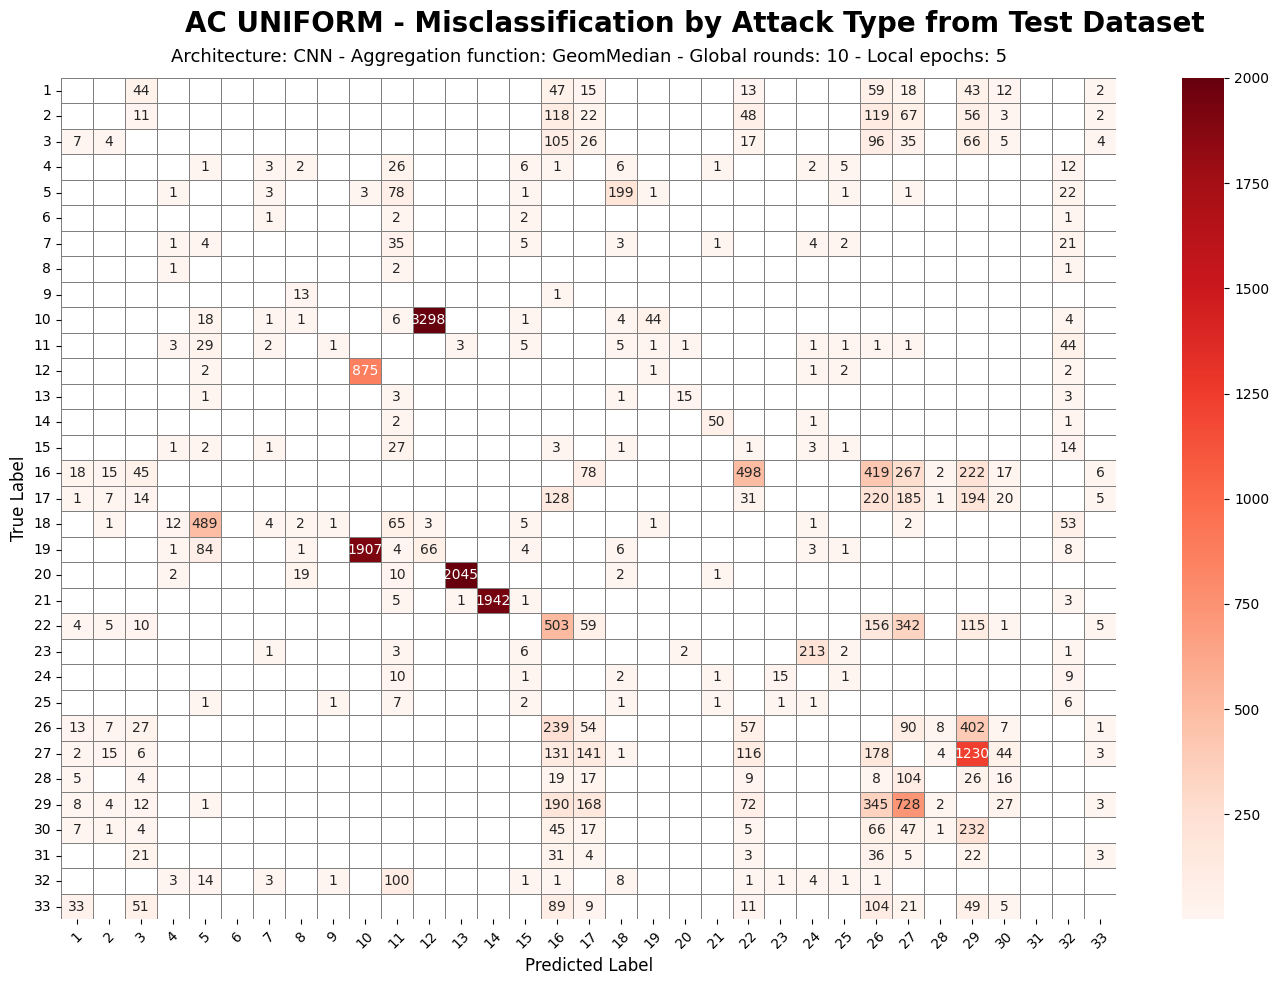

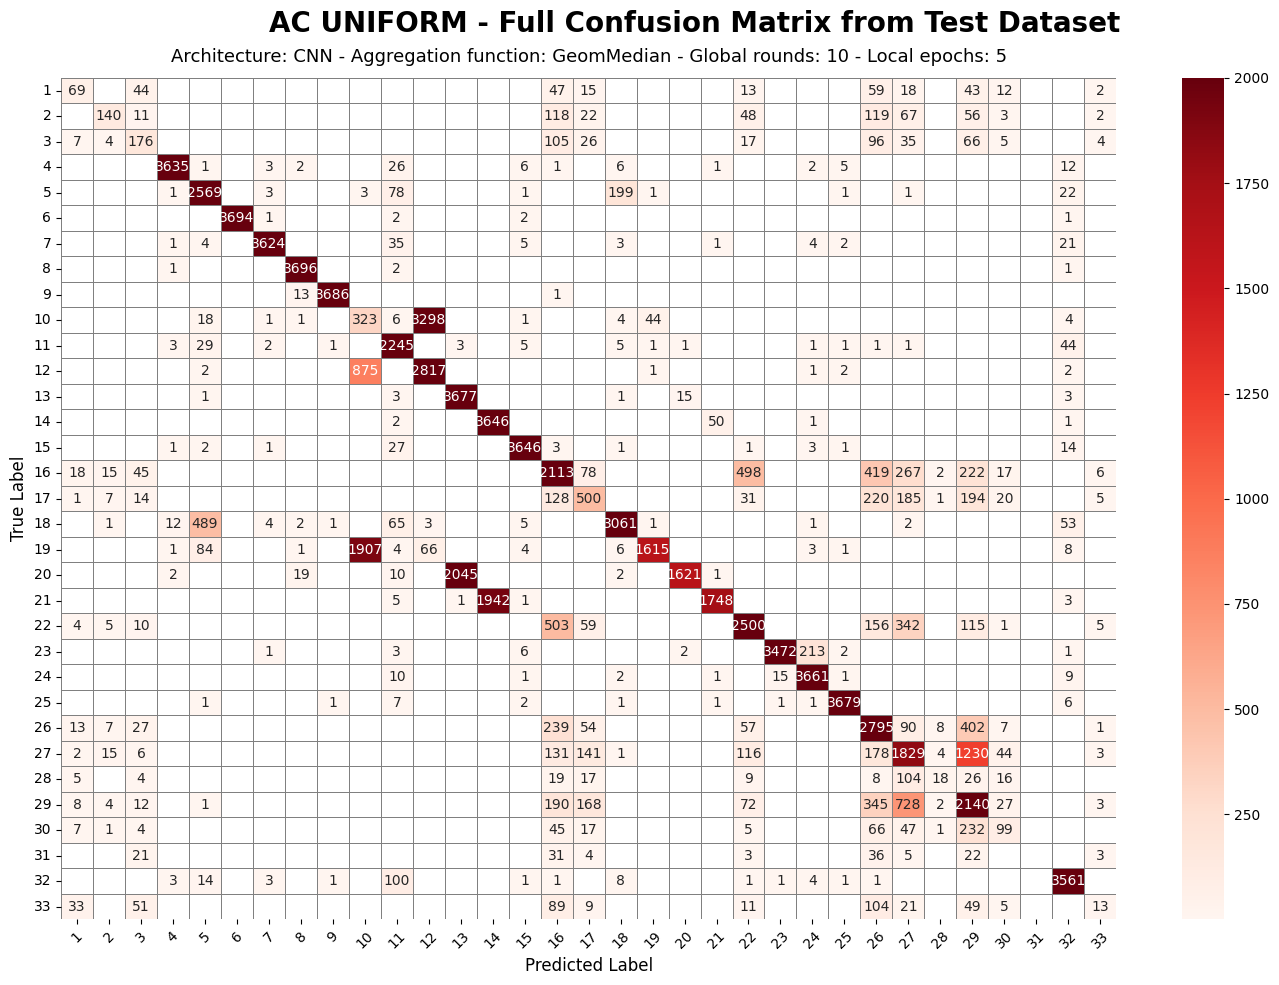

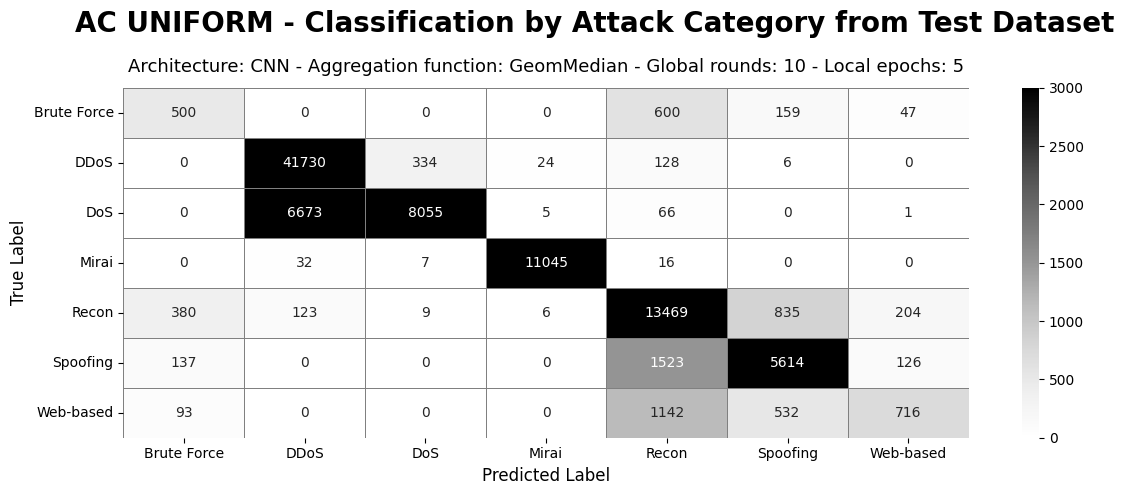


 ============== AC UNIFORM PARTITIONS: CNN (GeomMedian) ==============
 --------------- DP configuration: eps = 3, max_grad_norm = 1 --------------- 


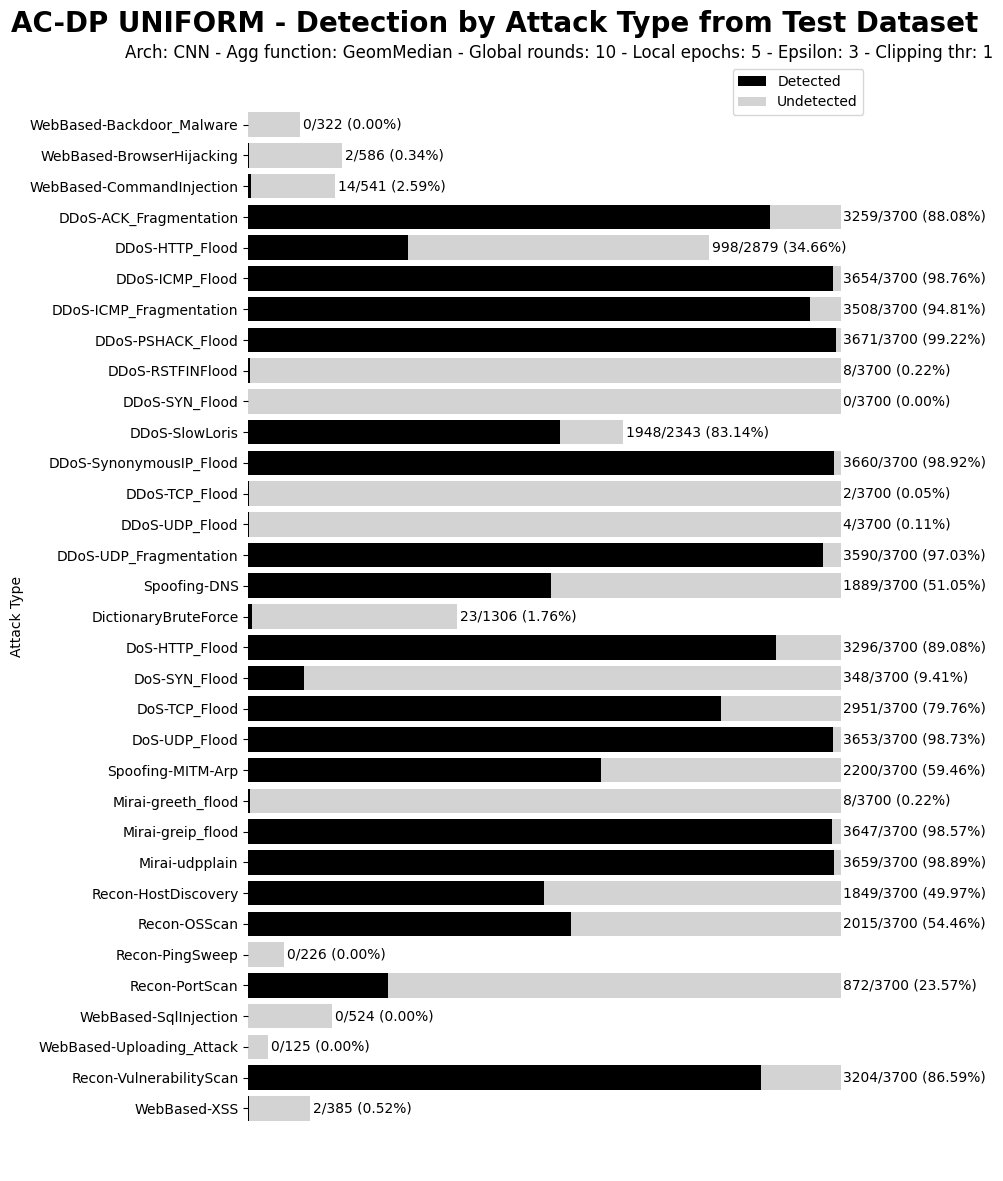

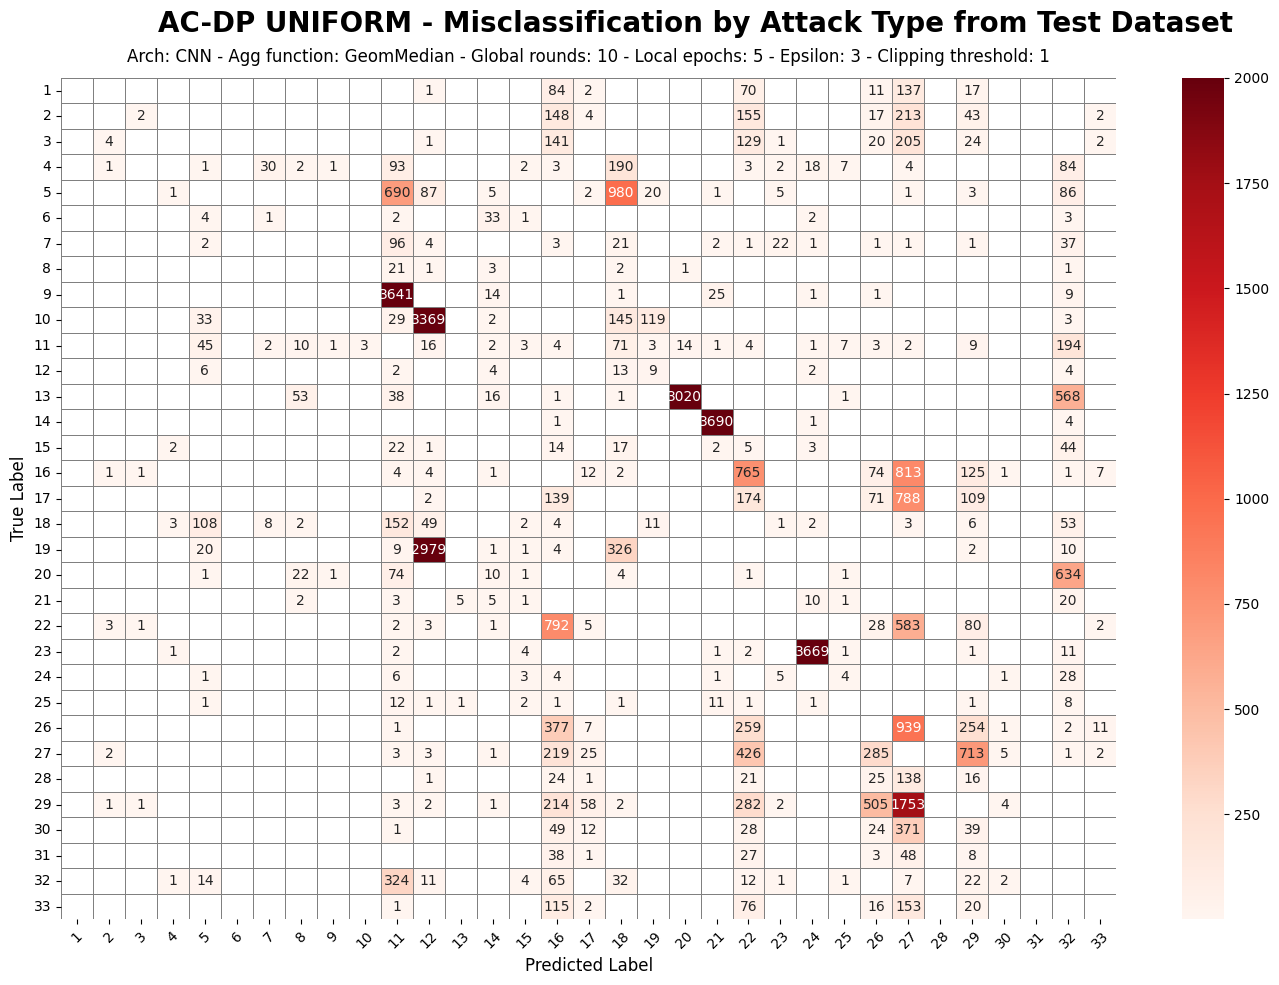

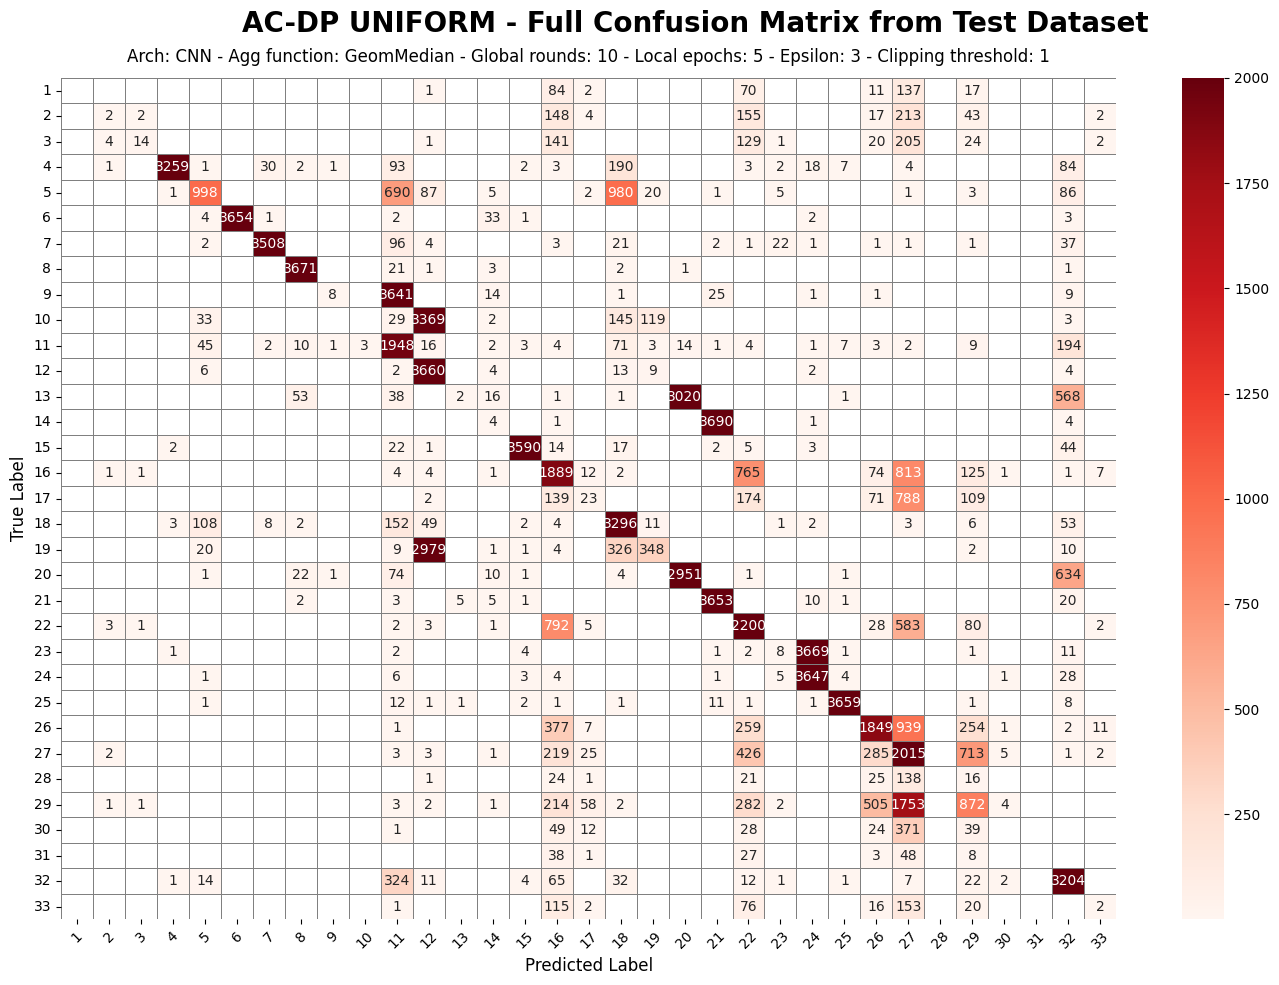

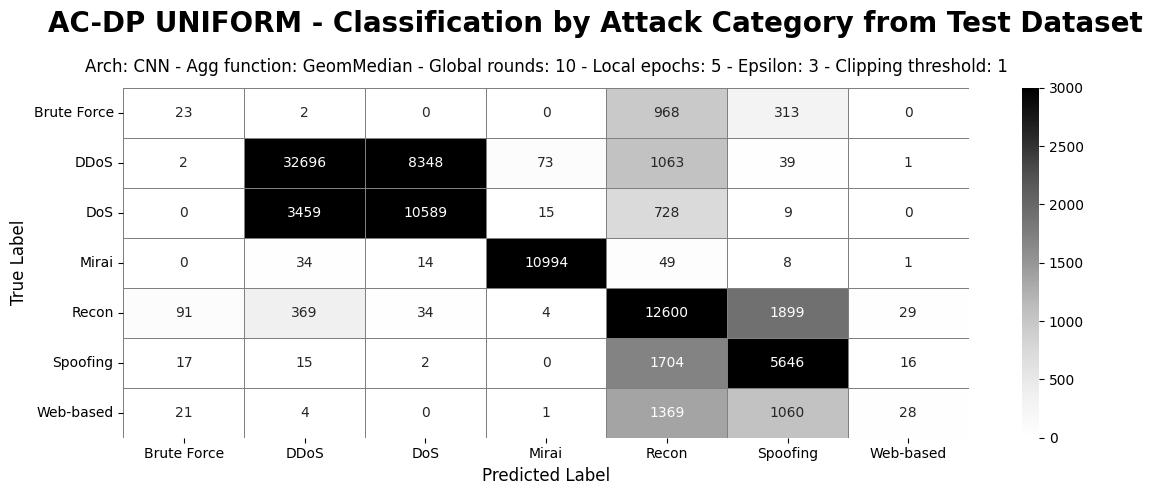


 ============== AC UNBALANCED PARTITIONS: CNN (GeomMedian) ==============


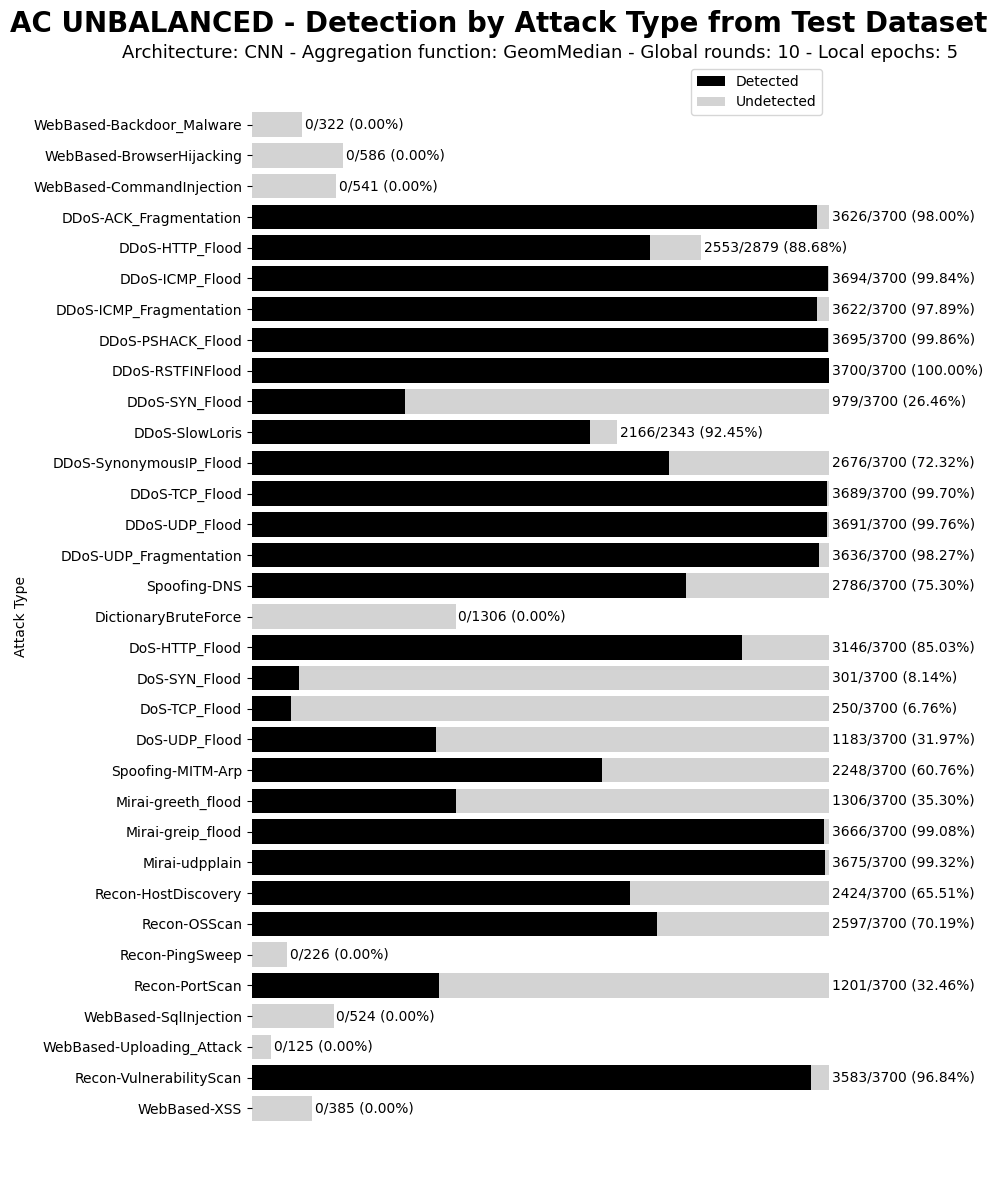

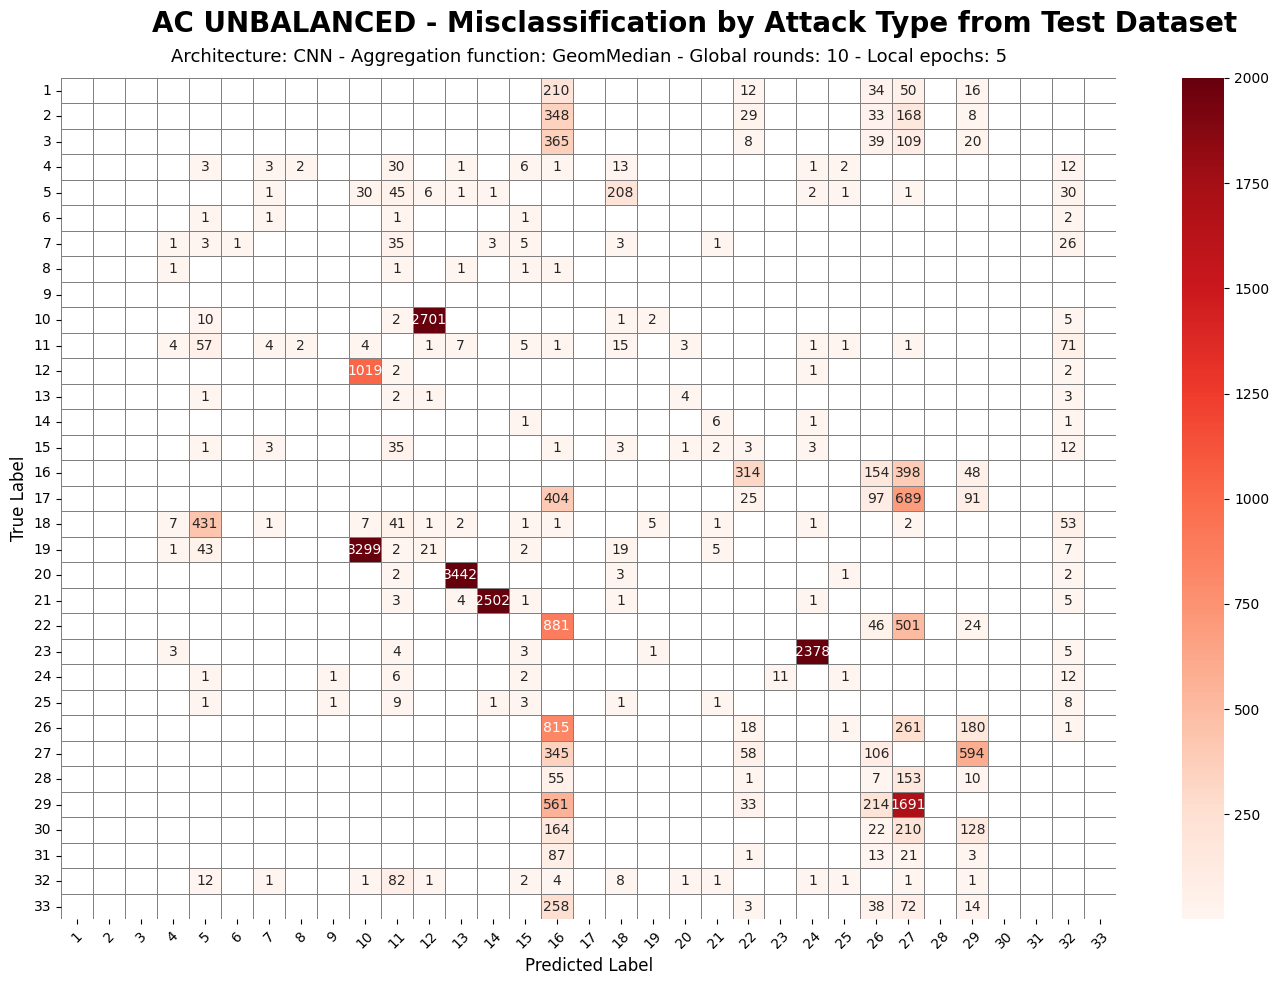

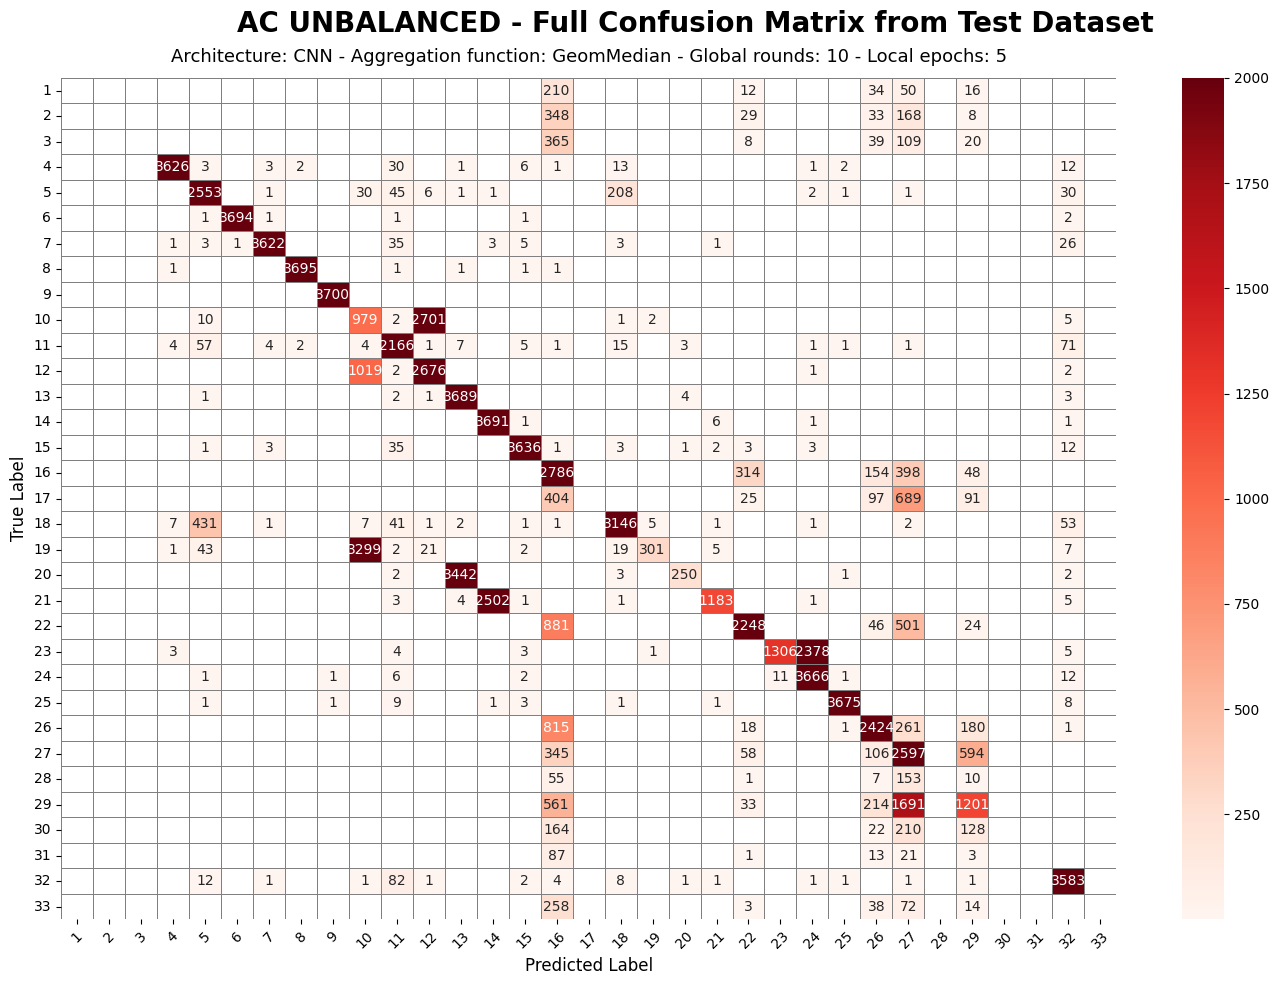

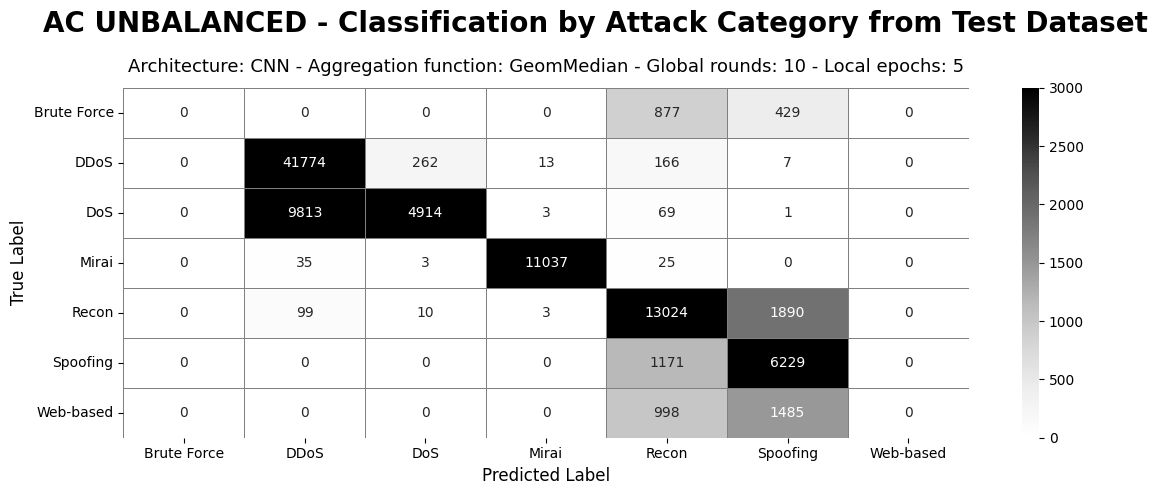


 ============== AC UNBALANCED PARTITIONS: CNN (GeomMedian) ==============
 --------------- DP configuration: eps = 3, max_grad_norm = 1 --------------- 


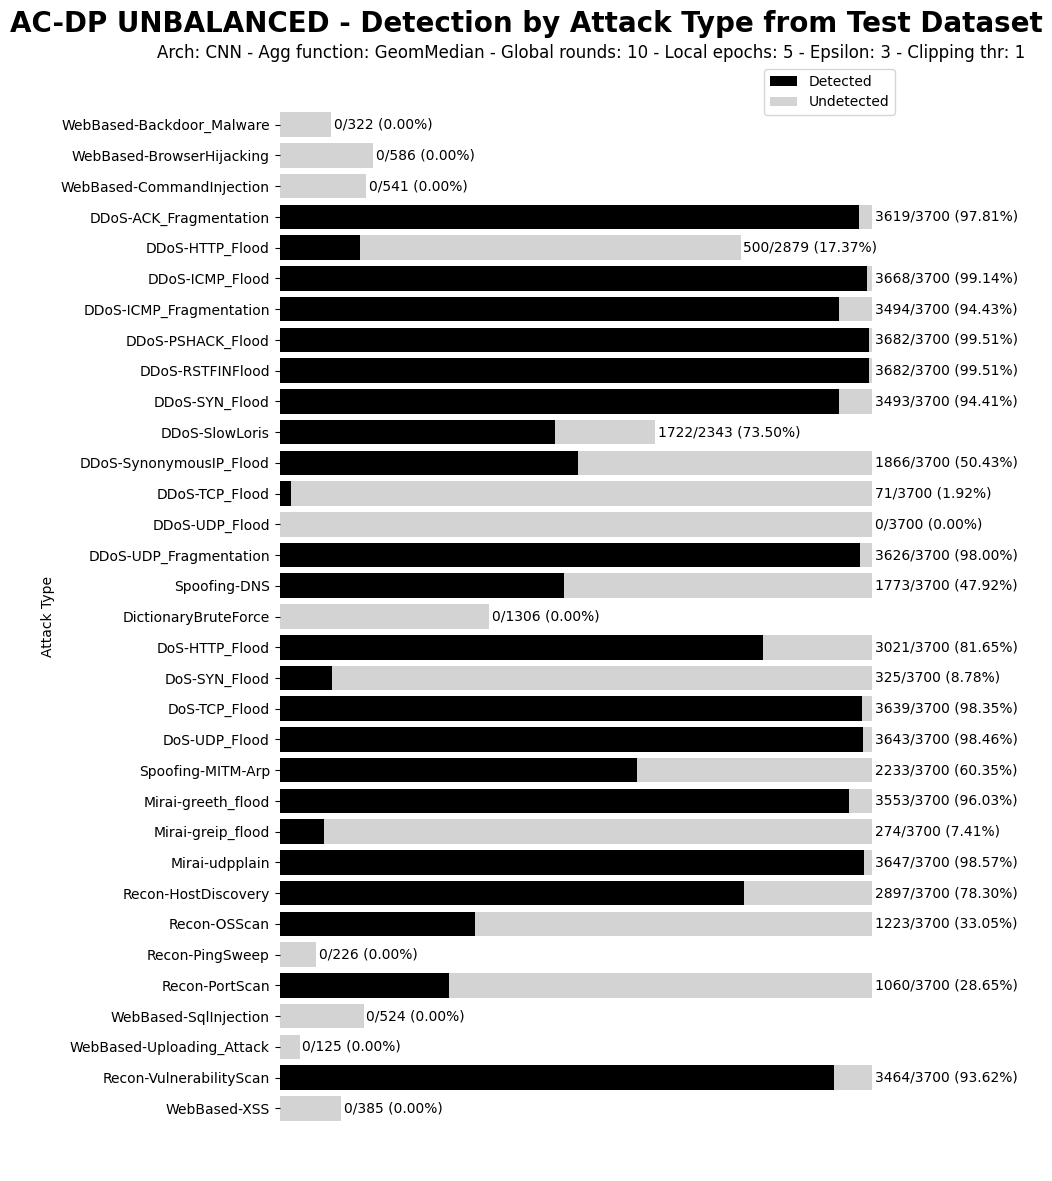

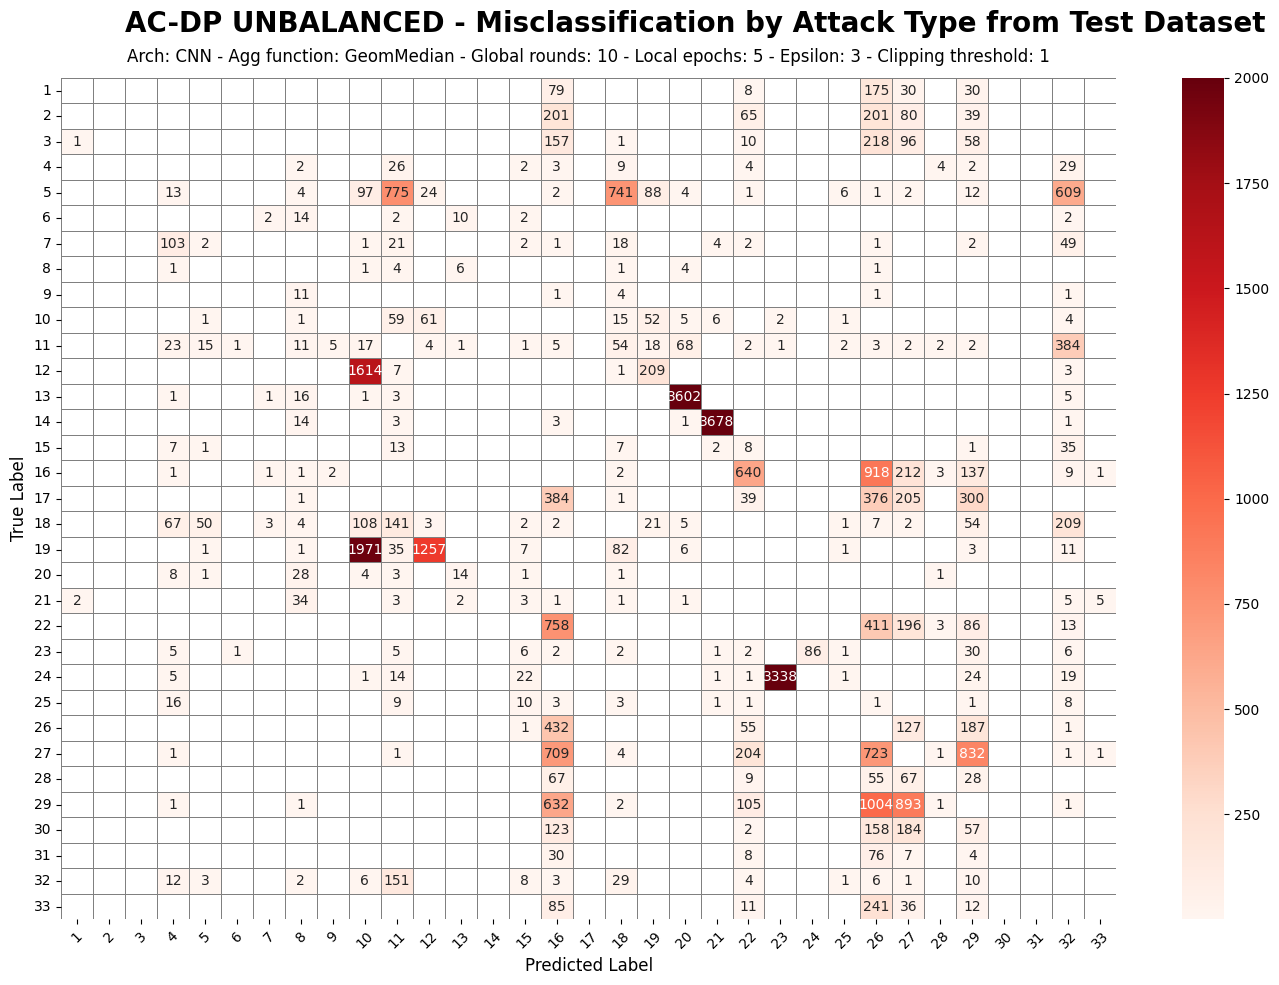

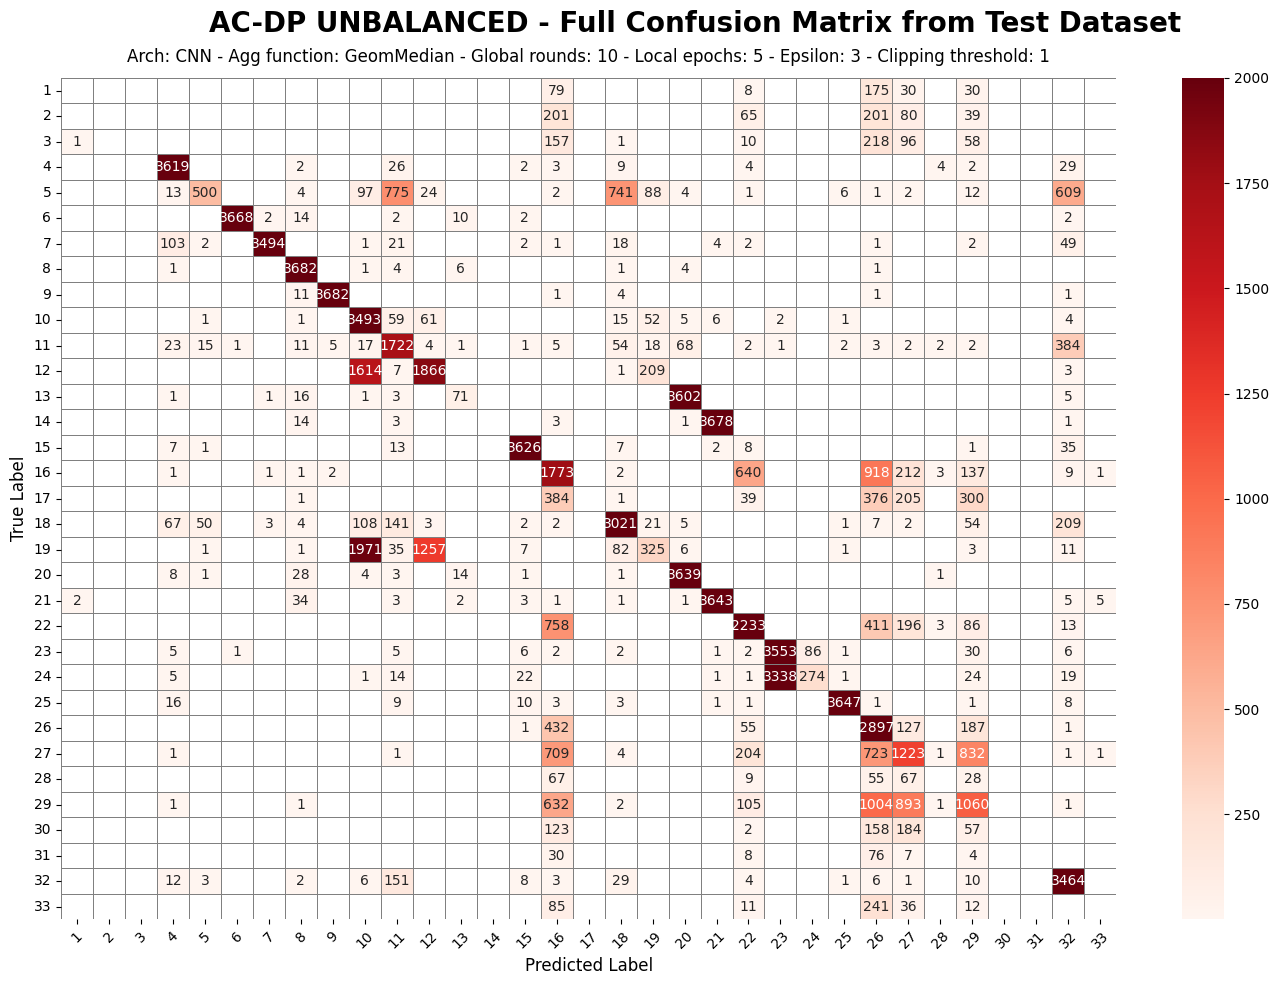

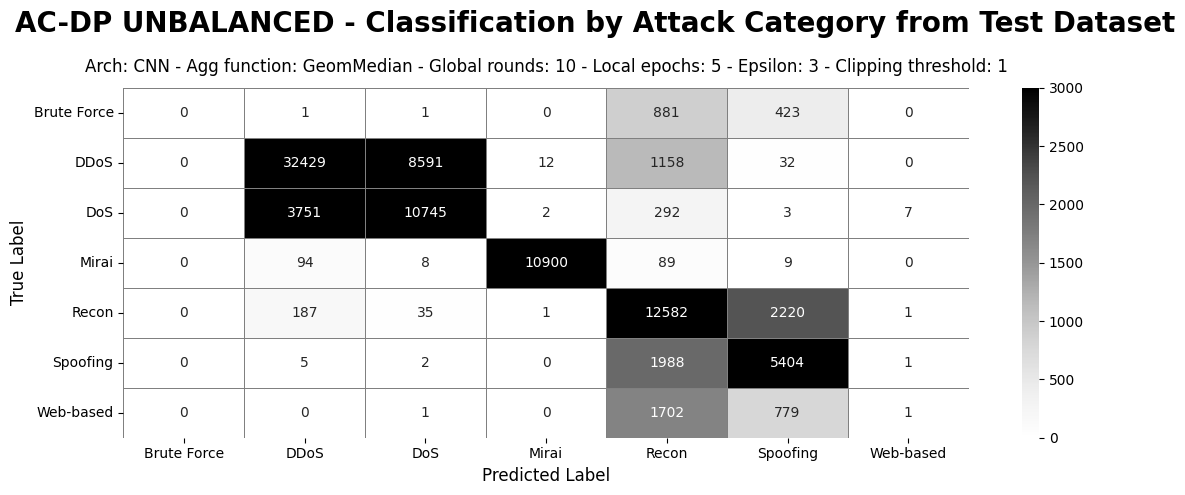

In [ ]:
AC_models_dict = {'Model': [], 'AD Model': [], 'Partition': [], 'Conf': [], 'Strategy': [], 'Rounds': [], 'Epochs': [], 'Precision': [], 'Precision (Indiv)': [], 'Recall': [], 'Recall (Indiv)': [],  'F1-score': [],  'F1-score (Indiv)': [], 'Accuracy': [], 'MCC':[]}

AC_model_name = 'CNN'
AC_agg_funct = 'GeomMedian'
AC_models_test, AC_y_pred = {}, {}
AC_model = deepcopy(AC_models[AC_model_name])
X_test, y_test = test_dataset(MODE)

ACDP = {'AC3': 1} # Differential Privacy configuration

for AC_partition in ['UNIFORM', 'UNBALANCED']:
    for conf in ['', '3']: # '' = No DP, '3' = DP
        extra = f"_DP{conf}" if conf else ''
        path = "DP/" if conf else ''

        # Load model weights
        AC_models_test[f"{AC_partition}-{MODE}{EPOCHS}{extra}"] = deepcopy(AC_model)
        AC_models_test[f"{AC_partition}-{MODE}{EPOCHS}{extra}"].load_state_dict(torch.load(glob.glob(f"..\\models\\{MODE}\\{path}{MODE}{EPOCHS}{extra}_{AC_partition}_{AC_model_name}_{AC_agg_funct}_r9.pth")[0], weights_only=True, map_location=device))
    
        AC_models_dict['Model'].append(AC_model_name)
        AC_models_dict['AD Model'].append("Test Dataset")
        AC_models_dict['Strategy'].append(AC_agg_funct)
        AC_models_dict['Partition'].append(AC_partition)
        AC_models_dict['Conf'].append(f"{conf}-{ACDP[f'{MODE}{conf}']}" if conf else None)
        AC_models_dict['Rounds'].append(NUM_ROUNDS-1)
        AC_models_dict['Epochs'].append(EPOCHS)
        
        print(f"\n ============== {MODE} {AC_partition} PARTITIONS: {AC_model_name} ({AC_agg_funct}) ==============")
        if conf: 
            print(f" --------------- DP configuration: eps = {conf.split('-')[0]}, max_grad_norm = {ACDP[f'{MODE}{conf}']} --------------- ")
        AC_models_dict, AC_y_pred[f"{AC_partition}-{MODE}{EPOCHS}{extra}"] = evaluation(AC_models_test[f"{AC_partition}-{MODE}{EPOCHS}{extra}"], X_test, y_test, df_labels, AC_model_best_params[AC_model_name]['batch_size'], AC_models_dict)

DisplayTable(pd.DataFrame(AC_models_dict))

In [17]:
for partition in ["UNIFORM", "UNBALANCED"]:
    modelNODP = AC_models_test[f"{partition}-AC5"]
    modelDP = AC_models_test[f"{partition}-AC5_DP3"]

    print(f"\n ============== {MODE} {partition} PARTITIONS ============== ")
    
    kl_nodp_dp, kl_dp_nodp, js_nodp = compute_divergences(modelNODP, modelDP, X_test, y_test, AC_model_best_params[AC_model_name]['batch_size'])
    
    print(f"\nKL Divergence (non-DP || DP): {kl_nodp_dp:.4f}") # How much info is lost using model2 to approximate model1
    print(f"KL Divergence (DP || non-DP): {kl_dp_nodp:.4f}")
    print(f"Jensen-Shannon Divergence:     {js_nodp:.4f}")


 ============== AC UNIFORM PARTITIONS ============== 

KL Divergence (non-DP || DP): 2.9098
KL Divergence (DP || non-DP): 3.0212
Jensen-Shannon Divergence:     0.2123

 ============== AC UNBALANCED PARTITIONS ============== 

KL Divergence (non-DP || DP): 3.1489
KL Divergence (DP || non-DP): 2.5739
Jensen-Shannon Divergence:     0.2088


## **FULL IDS**

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.metrics._classification")
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

Full_model_name = 'CNN'
Full_agg_funct = 'GeomMedian'
Full_models_test, Full_y_pred = {}, {}
Full_model = deepcopy(AC_models[AC_model_name]) # Load base model for AC
    
ACDP = {'AC3': 1} # DP config

for partition in ['UNIFORM', 'UNBALANCED']:
    for conf in ['', '3']:
        (extra, extraAD) = (f"_DP{conf}", "_DP2") if conf else ('', '')
        path = "DP/" if conf else ''
        
        df_test = preprocessing(pd.read_csv("..\\datasets\\df_test.csv"), df_labels)
        X_test, y_test_bin, y_test_multi = Split(df_test, True)
        
        y_test = y_test_multi # Multiclass labels
        
        print(f"\n ============== {MODE} {partition} PARTITIONS: {Full_model_name} ({Full_agg_funct}) ==============")
        if conf: 
            print(f" --------------- DP configuration: eps = {conf.split('-')[0]}, max_grad_norm = {ACDP[f'{MODE}{conf}']} --------------- ")

        # Initialize results tracking dictionary
        Full_models_dict = {'Model': [], 'AD Model': [], 'Partition': [], 'Conf': [], 'Strategy': [], 'Rounds': [], 'Epochs': [], 'Precision': [], 'Precision (Indiv)': [], 'Recall': [], 'Recall (Indiv)': [],  'F1-score': [],  'F1-score (Indiv)': [], 'Accuracy': [], 'MCC':[]}

        y_true_full, y_pred_full = [], []
        ad_preds = AD_y_pred[f"{partition}-AD{EPOCHS}{extraAD}"]
        ac_preds = AC_y_pred[f"{partition}-{MODE}{EPOCHS}{extra}"]

        # Mask of AD = 1 (attack), used to index multiclass AC predictions
        attack_mask = ad_preds == 1
        multi_idx = 0

        for i in range(len(y_test)):
            y_true_full.append(y_test[i].item())
            
            if ad_preds[i].item() == 0:
                y_pred_full.append(0)  # Predict "benign" traffic
            else:
                # Multiclass attack prediction (+1 shift to align with true labels)
                y_pred_full.append(ac_preds[multi_idx].item() + 1)
                multi_idx += 1
                    
        Full_models_dict['Model'].append(Full_model_name)
        Full_models_dict['AD Model'].append(f"{partition}-AD{EPOCHS}{extraAD}")
        Full_models_dict['Strategy'].append(Full_agg_funct)
        Full_models_dict['Partition'].append(partition)
        Full_models_dict['Conf'].append(f"{conf}-{ACDP[f'{MODE}{conf}']}" if conf else None)
        Full_models_dict['Rounds'].append(NUM_ROUNDS-1)
        Full_models_dict['Epochs'].append(EPOCHS)

        # Compute full metrics and siplay evaluation table
        Full_models_dict = metrics_dict(Full_models_dict, y_true_full, y_pred_full, 'weighted')
        DisplayTable(pd.DataFrame(Full_models_dict))


 ============== AC UNIFORM PARTITIONS: CNN (GeomMedian) ==============



 ============== AC UNIFORM PARTITIONS: CNN (GeomMedian) ==============
 --------------- DP configuration: eps = 3, max_grad_norm = 1 --------------- 



 ============== AC UNBALANCED PARTITIONS: CNN (GeomMedian) ==============



 ============== AC UNBALANCED PARTITIONS: CNN (GeomMedian) ==============
 --------------- DP configuration: eps = 3, max_grad_norm = 1 --------------- 



 ============== AC UNIFORM PARTITIONS: CNN (GeomMedian) ==============


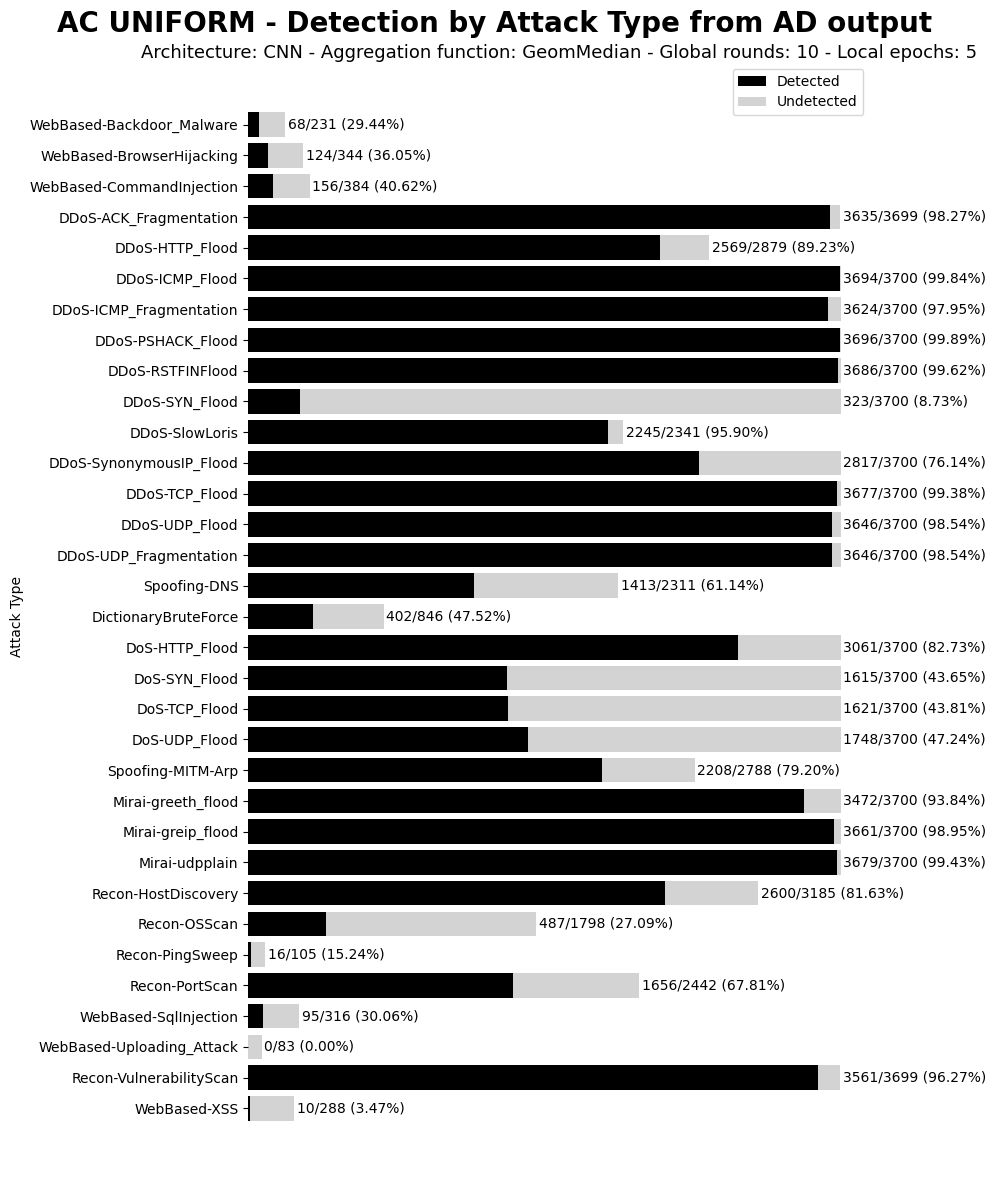

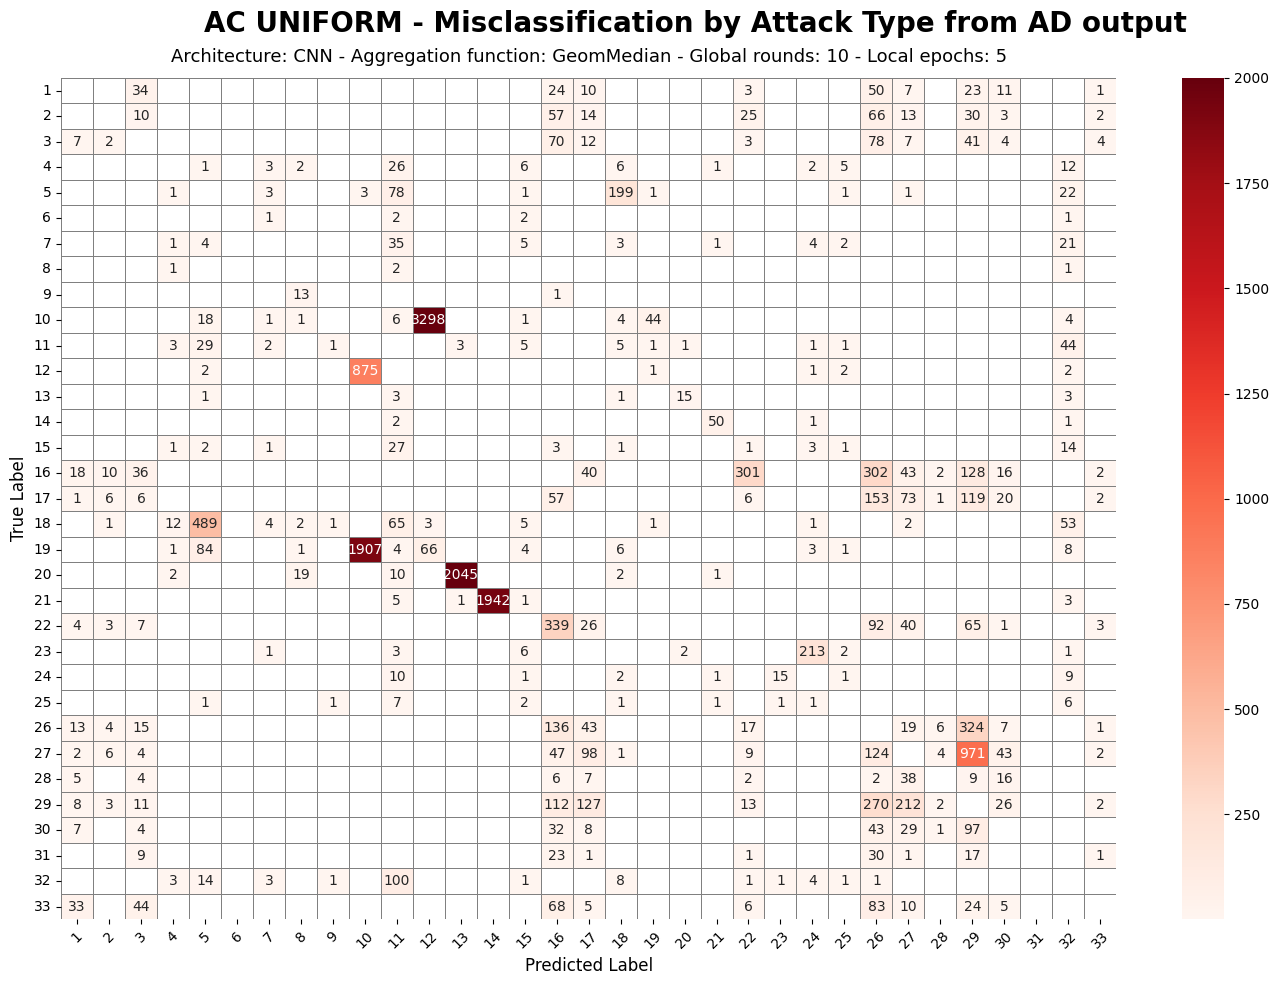

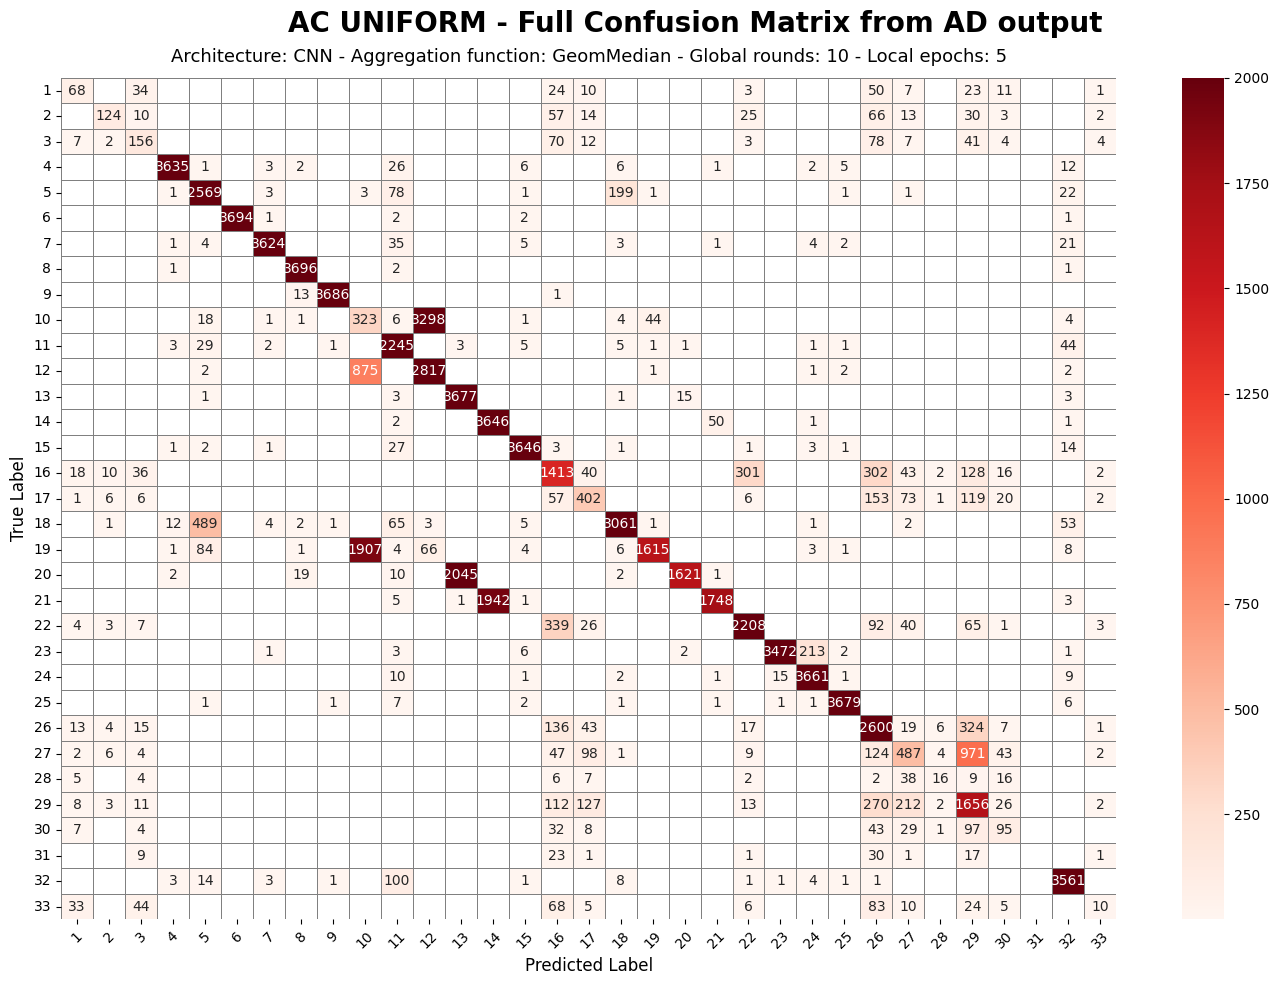

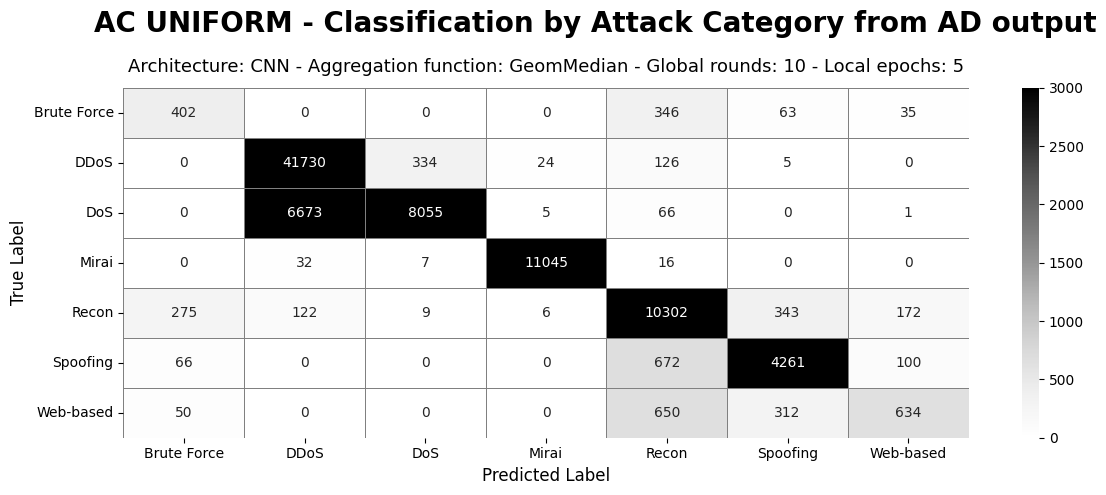


 ============== AC UNIFORM PARTITIONS: CNN (GeomMedian) ==============
 --------------- DP configuration: eps = 3, max_grad_norm = 1 --------------- 


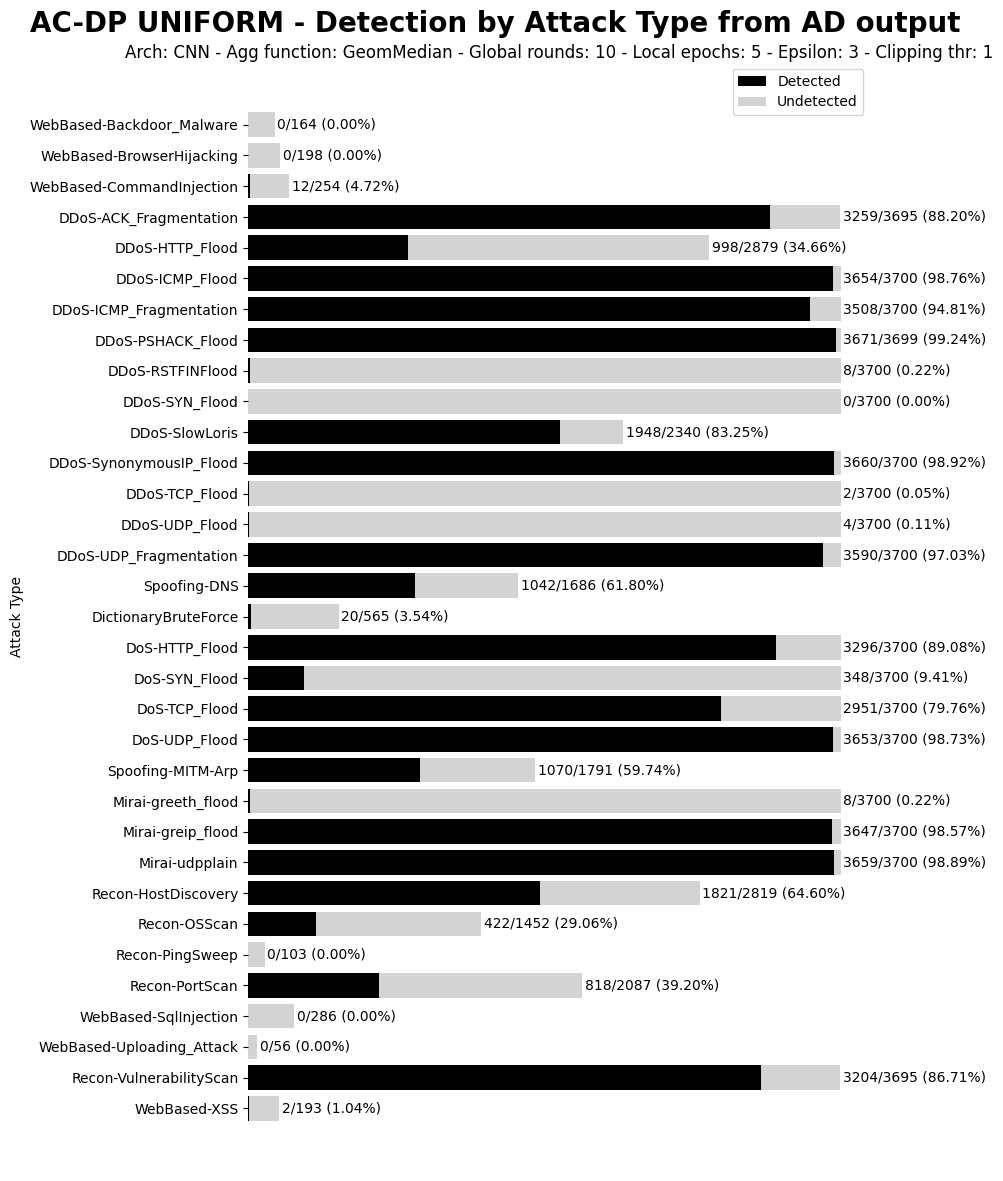

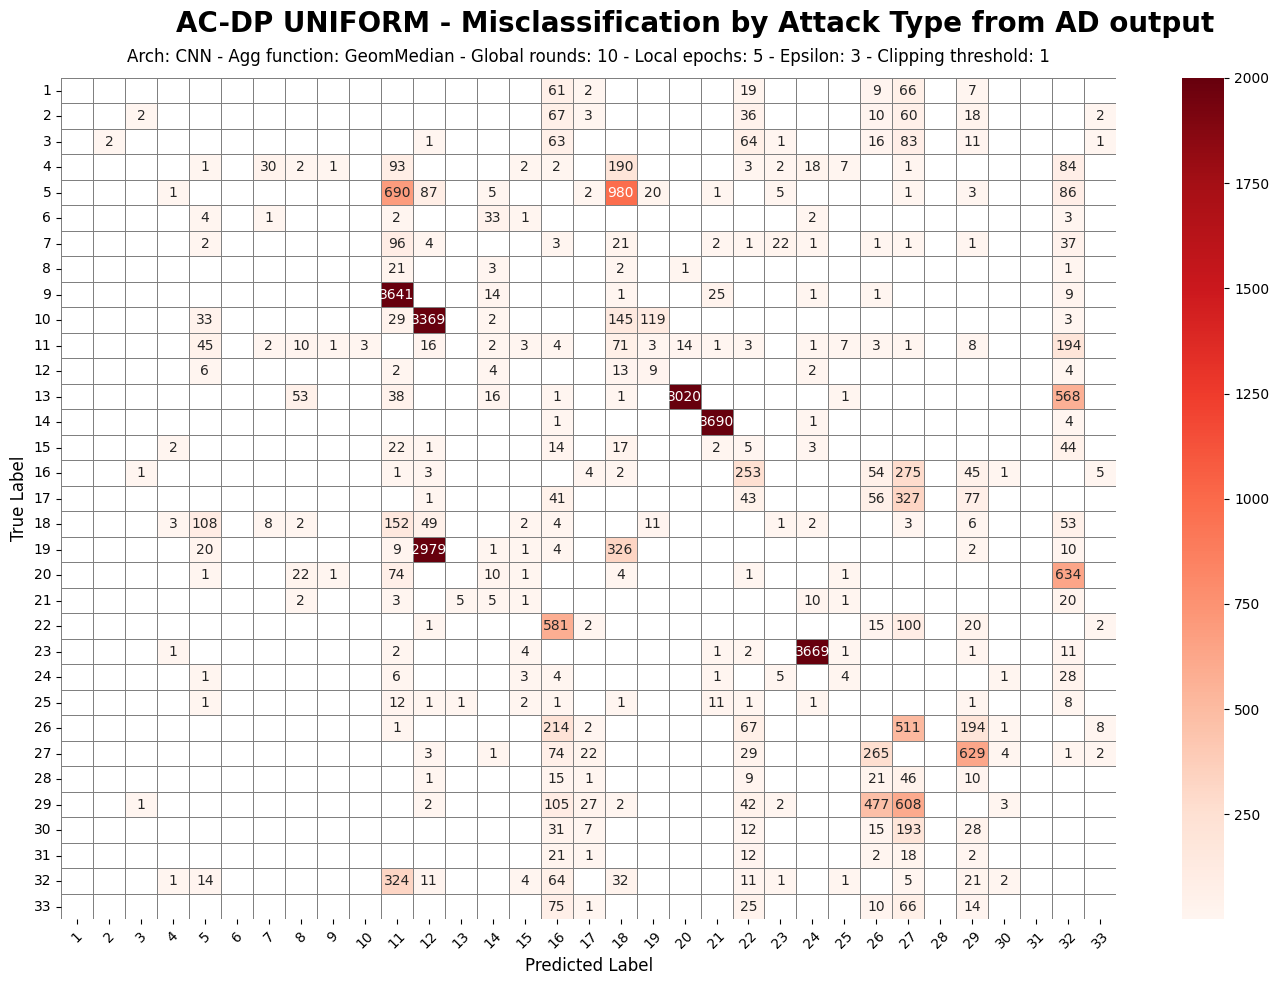

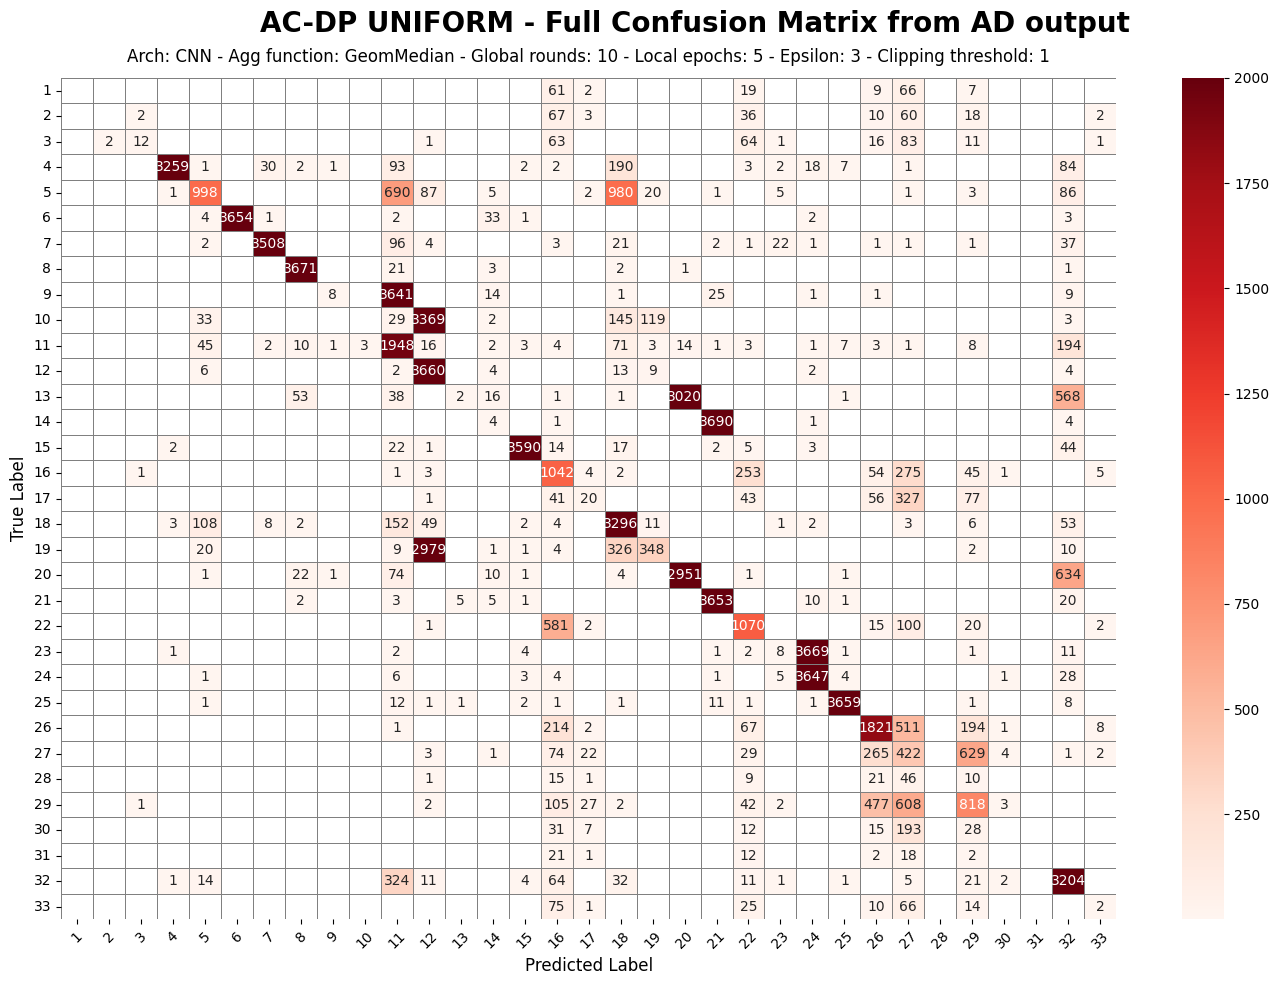

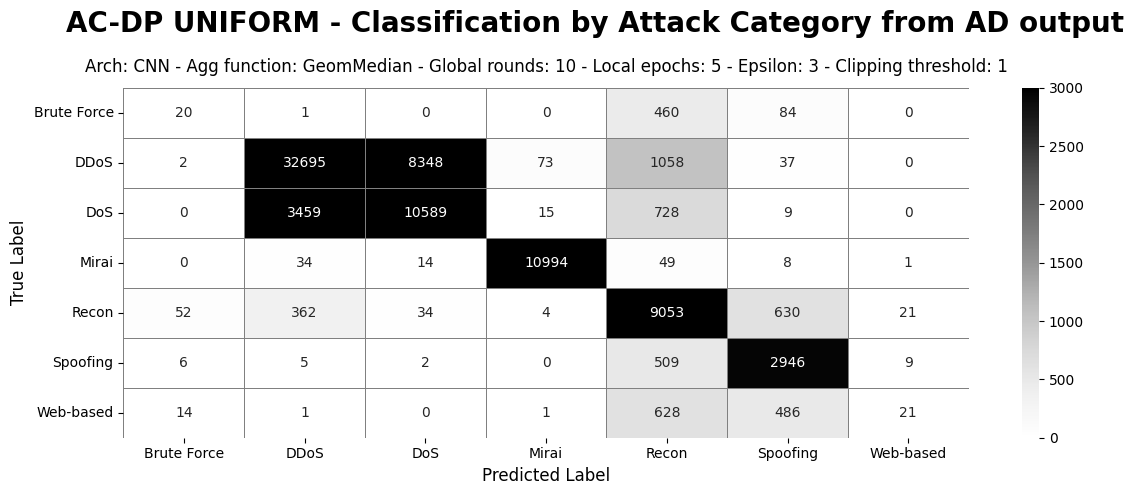


 ============== AC UNBALANCED PARTITIONS: CNN (GeomMedian) ==============


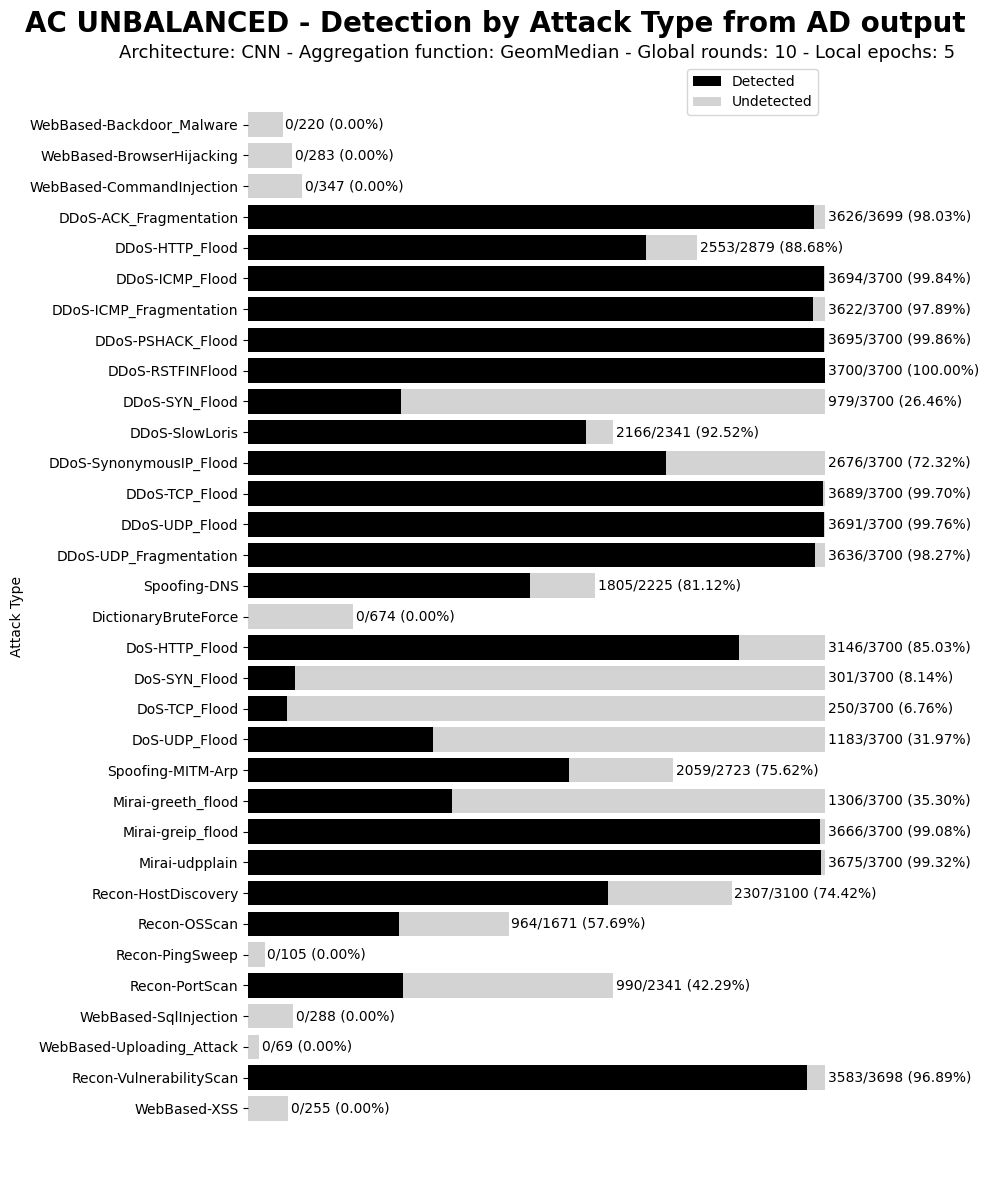

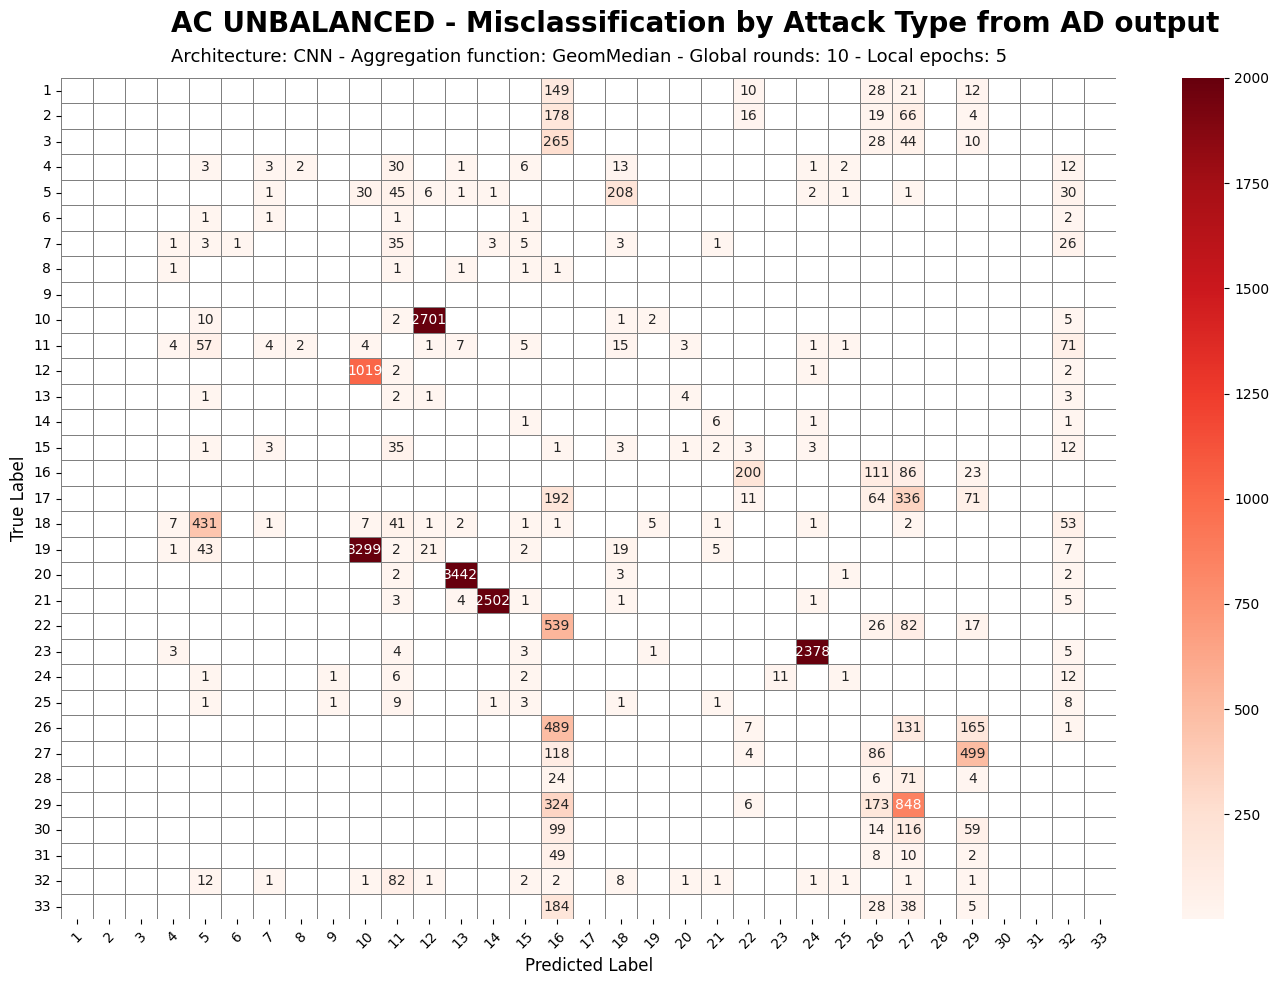

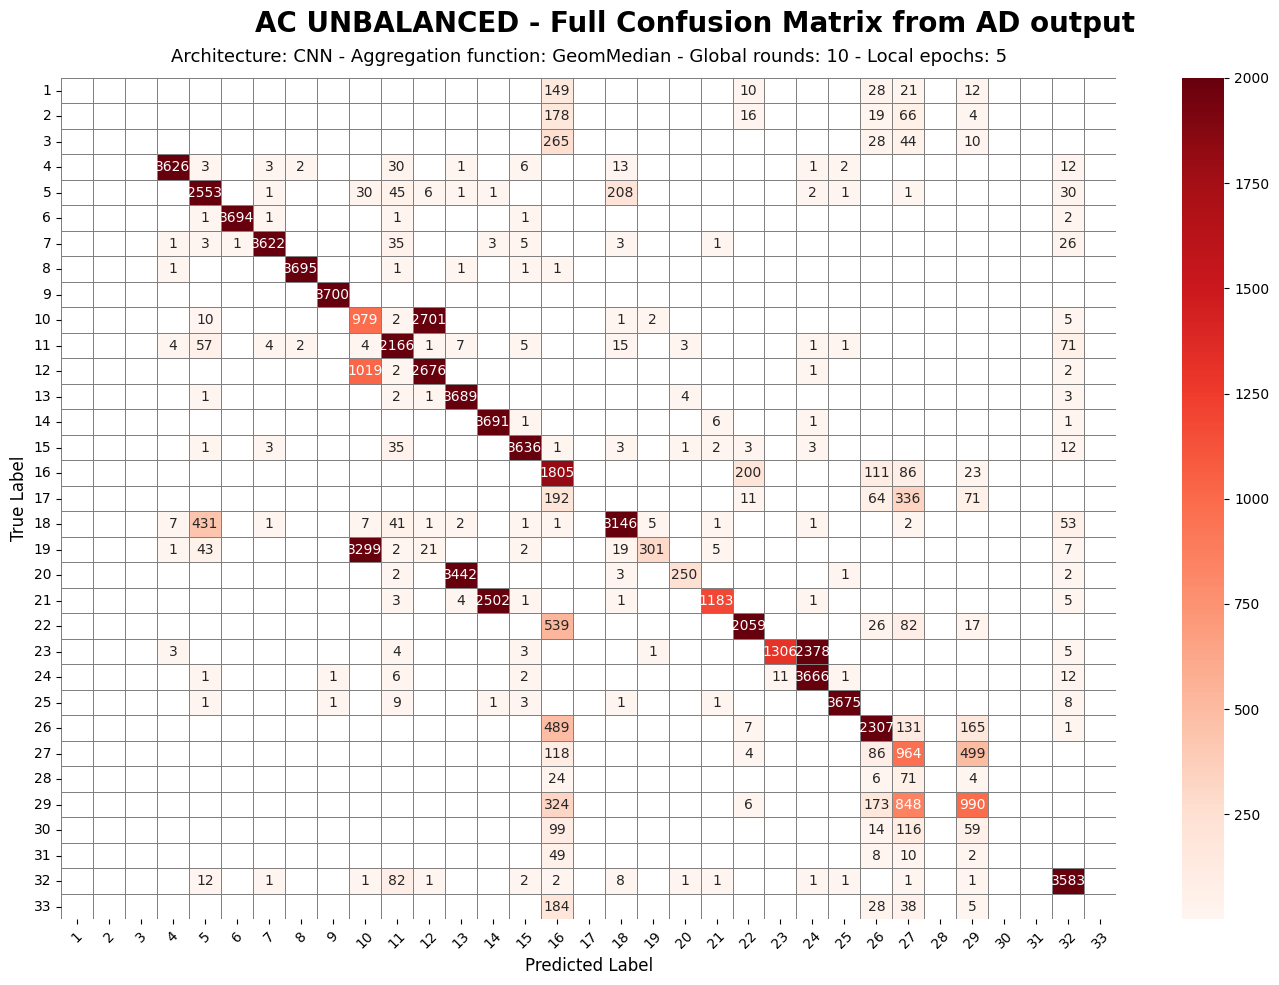

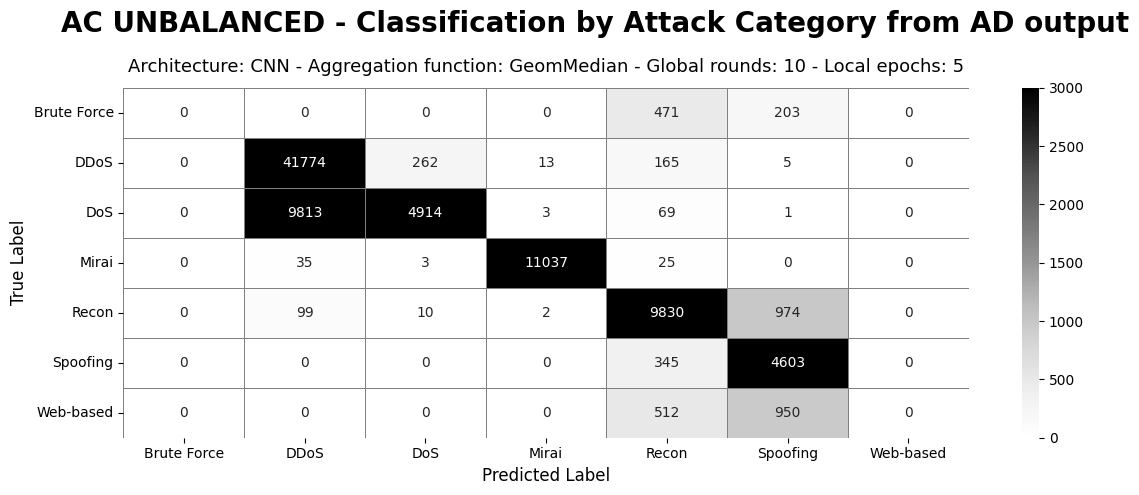


 ============== AC UNBALANCED PARTITIONS: CNN (GeomMedian) ==============
 --------------- DP configuration: eps = 3, max_grad_norm = 1 --------------- 


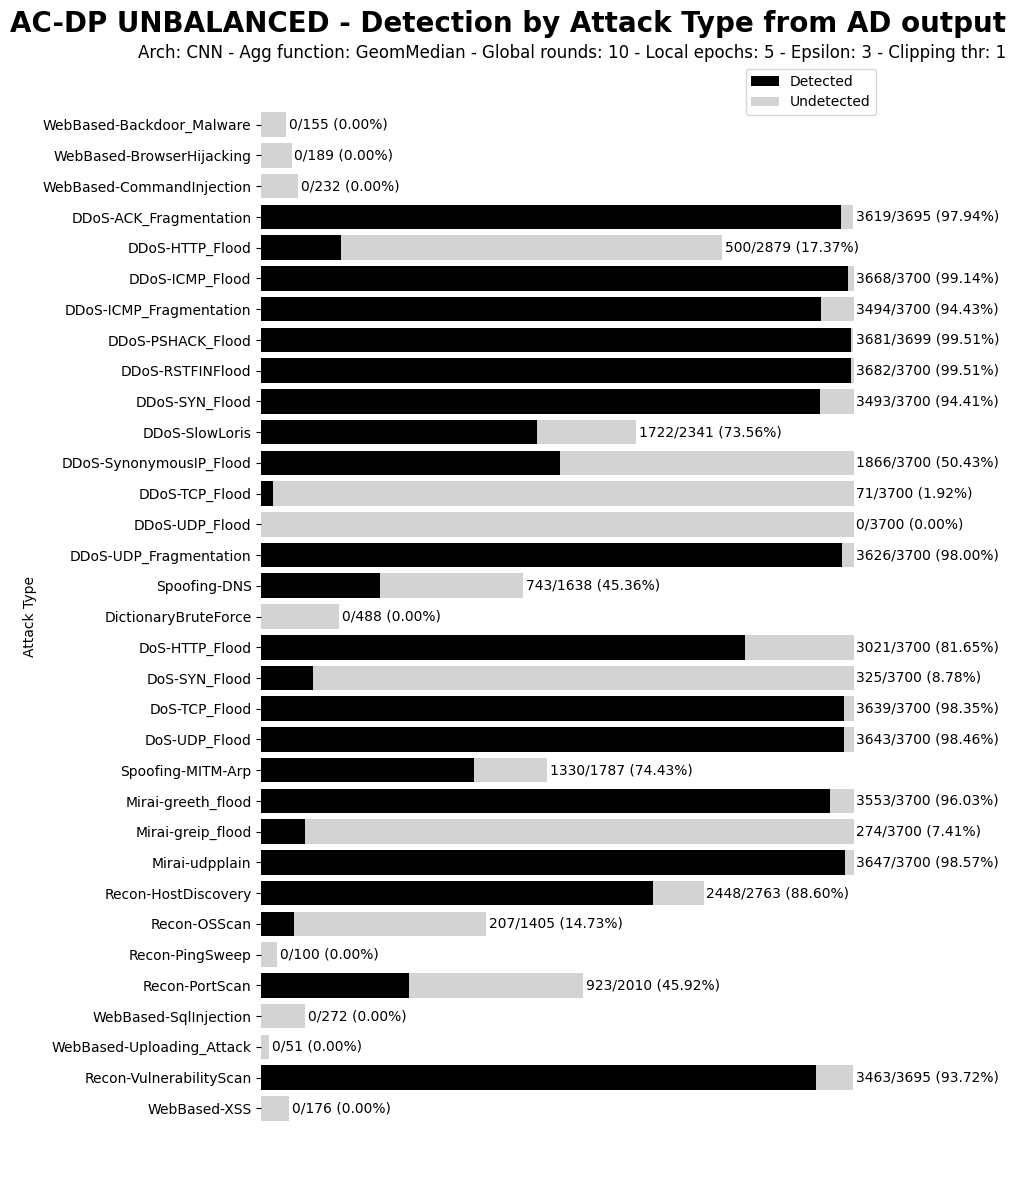

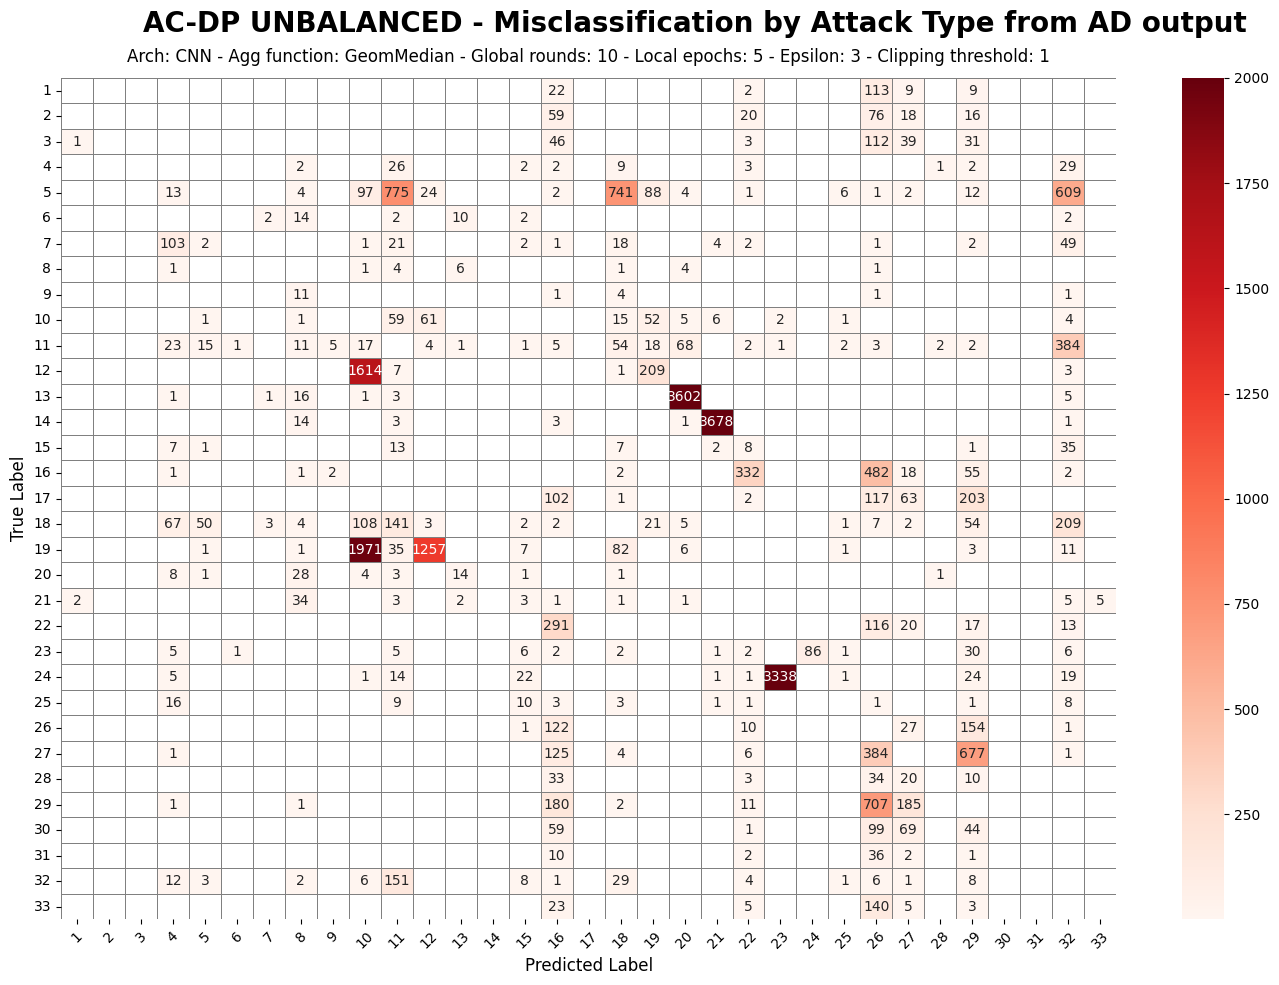

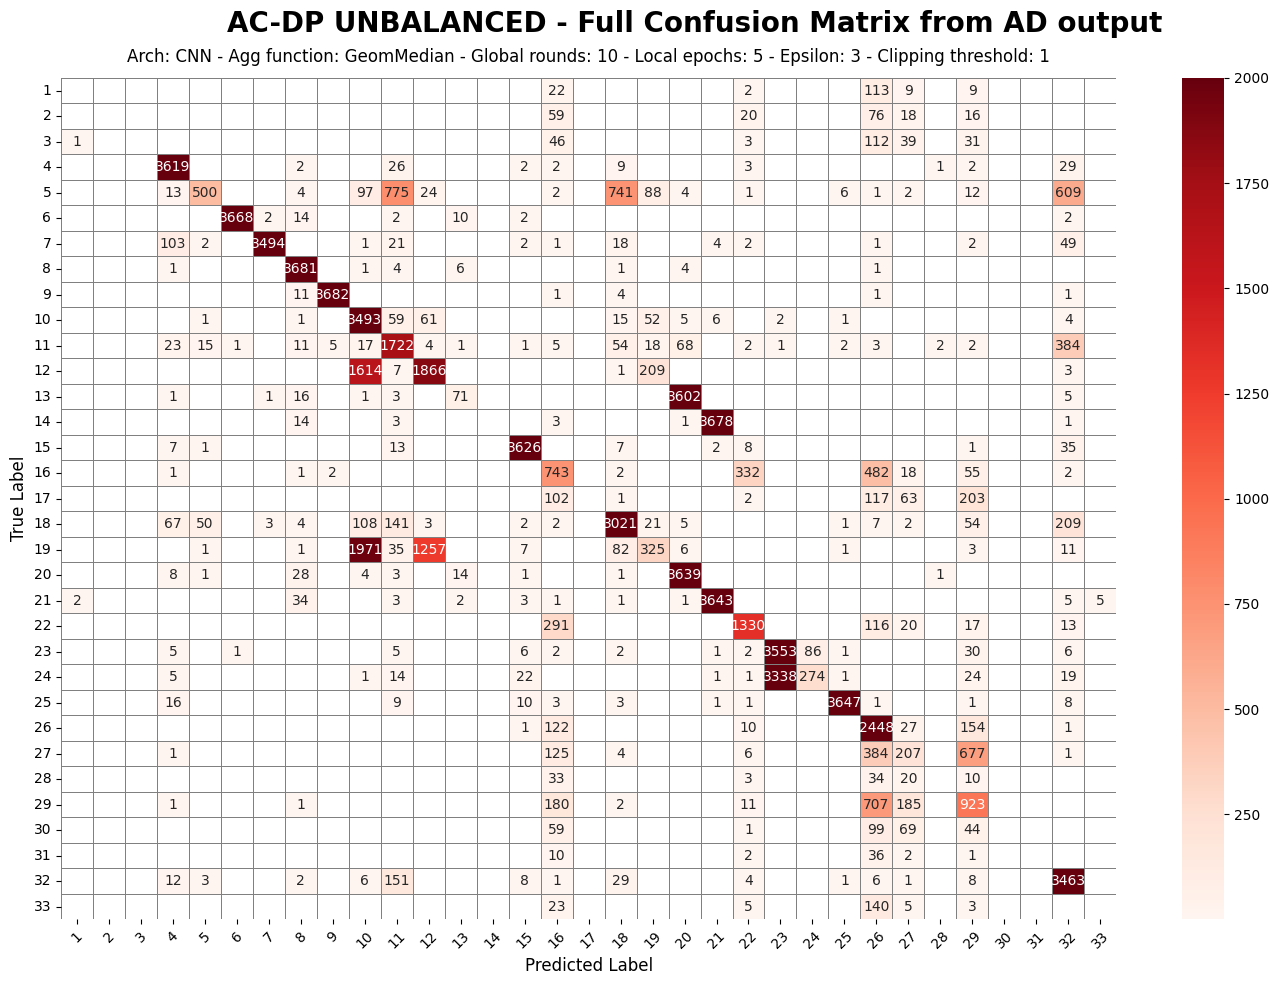

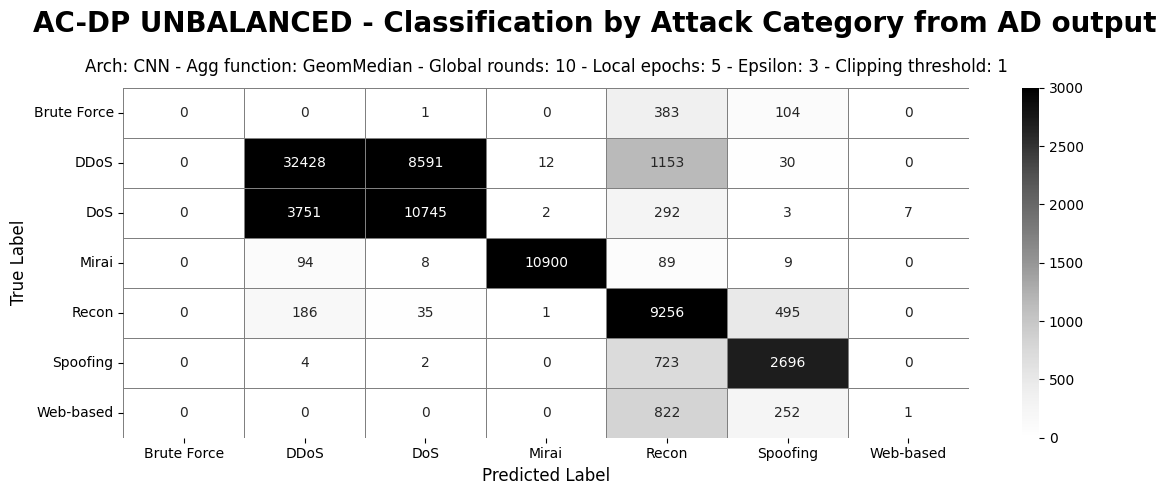

In [ ]:
Full_models_dict = {'Model': [], 'AD Model': [], 'Partition': [], 'Conf': [], 'Strategy': [], 'Rounds': [], 'Epochs': [], 'Precision': [], 'Precision (Indiv)': [], 'Recall': [], 'Recall (Indiv)': [],  'F1-score': [],  'F1-score (Indiv)': [], 'Accuracy': [], 'MCC':[]}

Full_models_test, Full_y_pred = {}, {}
Full_model = deepcopy(AC_models[AC_model_name])

ACDP = {'AC3': 1}

for partition in ['UNIFORM', 'UNBALANCED']:
    for conf in ['', '3']:
        (extra, extraAD) = (f"_DP{conf}", "_DP2") if conf else ('', '')
        path = "DP/" if conf else ''
        X_test, y_test = test_dataset(MODE, limit=AD_y_pred[f"{partition}-AD{EPOCHS}{extraAD}"])
        
        Full_models_test[f"{partition}-{MODE}{EPOCHS}{extra}"] = deepcopy(Full_model)
        Full_models_test[f"{partition}-{MODE}{EPOCHS}{extra}"].load_state_dict(torch.load(glob.glob(f"..\\models\\{MODE}\\{path}{MODE}{EPOCHS}{extra}_{partition}_{Full_model_name}_{Full_agg_funct}_r9.pth")[0], weights_only=True, map_location=device))
    
        Full_models_dict['Model'].append(Full_model_name)
        Full_models_dict['AD Model'].append(f"{partition}-AD{EPOCHS}{extraAD}")
        Full_models_dict['Strategy'].append(Full_agg_funct)
        Full_models_dict['Partition'].append(partition)
        Full_models_dict['Conf'].append(f"{conf}-{ACDP[f'{MODE}{conf}']}" if conf else None)
        Full_models_dict['Rounds'].append(NUM_ROUNDS-1)
        Full_models_dict['Epochs'].append(EPOCHS)
        
        print(f"\n ============== {MODE} {partition} PARTITIONS: {Full_model_name} ({Full_agg_funct}) ==============")
        if conf: 
            print(f" --------------- DP configuration: eps = {conf.split('-')[0]}, max_grad_norm = {ACDP[f'{MODE}{conf}']} --------------- ")
        Full_models_dict, Full_y_pred[f"{partition}-{MODE}{EPOCHS}{extra}"] = evaluation(Full_models_test[f"{partition}-{MODE}{EPOCHS}{extra}"], X_test, y_test, df_labels, AC_model_best_params[Full_model_name]['batch_size'], Full_models_dict)

DisplayTable(pd.DataFrame(Full_models_dict))
